In [1]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import requests
from pyathena import connect
import json
import io
from bs4 import BeautifulSoup
from scipy.stats import zscore
from collections import Counter, defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sagemaker import get_execution_role, clarify
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from tqdm import tqdm
from dotenv import load_dotenv
from typing import Dict
from smclarify.bias import report
import re
import os
import s3fs
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)


In [3]:
# get current path

current_path = os.getcwd()


Stored 'current_path' (str)


# Data Extraction

## Retrieving European Space Agency (ESA) Data

In [ ]:
load_dotenv()

# API Endpoint
esa_api_url = "https://discosweb.esoc.esa.int/api/objects"

# Your Personal Access Token
token = os.getenv('esa_token')

# Set up authentication headers
headers = {
    "Authorization": f"Bearer {token}",
    "DiscosWeb-Api-Version": "2",
    "Accept": "application/vnd.api+json"
}

# Query Parameters (Retrieving all object attributes)
params = {
    "page[size]": 100,  # Max allowed per page
}

# List to store all object records
all_data = []
page = 1  # Start with page 1

with tqdm(desc="Fetching Data", unit=" records", smoothing=0.1) as pbar:
    while True:
        params["page[number]"] = page  # Set current page number
        response = requests.get(esa_api_url, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            
            if "data" in data and data["data"]:
                all_data.extend(data["data"])  # Store raw data
                pbar.update(len(data["data"]))  # Update progress bar
            else:
                break  # Stop if no more data
            
            page += 1  # Move to next page
        else:
            print(f"❌ Error: {response.status_code}, {response.text}")
            break

# Extract all object attributes
esa_df = pd.DataFrame([obj["attributes"] for obj in all_data])

# Save as Parquet for efficiency
# esa_df.to_parquet("data/raw data/full_esa_data.parquet", index=False)

print(f"✅ Retrieved {len(satcat_df)} records and saved as Parquet!")


## Scrape Lost Object Data from CelesTrek

In [ ]:
# Base URL for lost satellites
base_url = "https://celestrak.org/satcat/lost.php"

# Initialize empty list to store data
all_rows = []

# Fetch the first page to determine pagination
response = requests.get(base_url)
if response.status_code != 200:
    print(f"Failed to retrieve data: {response.status_code}")
else:
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the total number of pages (if pagination exists)
    pagination = soup.find("div", class_="pagination")
    if pagination:
        pages = [a.text for a in pagination.find_all("a") if a.text.isdigit()]
        total_pages = max(map(int, pages)) if pages else 1
    else:
        total_pages = 1  # If no pagination, assume one page

    print(f"Total pages found: {total_pages}")

    # Loop through all pages
    for page in range(1, total_pages + 1):
        print(f"Scraping page {page}...")
        page_url = f"{base_url}?page={page}" if total_pages > 1 else base_url
        response = requests.get(page_url)
        
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}: {response.status_code}")
            continue
        
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find("table")
        
        if table:
            # Extract headers from first page only
            if page == 1:
                headers = [header.text.strip() for header in table.find_all("th")]

            # Extract data rows
            for row in table.find_all("tr")[1:]:  # Skip header row
                cols = [col.text.strip() for col in row.find_all("td")]
                if cols:
                    all_rows.append(cols)

# Convert to DataFrame
lost_object_satcat_df = pd.DataFrame(all_rows, columns=headers)

#Ingest to folder
# lost_object_satcat_df.to_csv("data/raw data/lost_objects.csv", index = False)



## Retrieve Low Earth Object data from Space Track

In [ ]:
# Space-Track login credentials
USERNAME = os.getenv('user')
PASSWORD = os.getenv('pass')

# Space-Track API URL for querying LEO satellites (sample query from website)
url = "https://www.space-track.org/basicspacedata/query/class/satcat/PERIOD/<128/DECAY/null-val/CURRENT/Y/"

# Create a session for authentication
session = requests.Session()

# Authenticate with space-track.org
login_url = "https://www.space-track.org/ajaxauth/login"
login_data = {"identity": USERNAME, "password": PASSWORD}
session.post(login_url, data=login_data)

# Fetch JSON data
response = session.get(url)

# Ensure request was successful
if response.status_code == 200:
    json_data = response.json()  # Convert response to JSON format

    # Convert JSON to Pandas DataFrame
    leo_satcat_df = pd.DataFrame(json_data)

    #leo_satcat_df.to_csv("data/raw data/leo_objects.csv", index = False)

else:
    print("Failed to retrieve data. Check credentials or API access.")
    print(response.text)



# Ingest into s3 bucket

In [ ]:
!aws s3 cp "data/raw data/full_esa_data.parquet" "s3://{bucket}/data/raw_data/full_esa_folder/"
!aws s3 cp "data/raw data/full_satcat.csv" "s3://{bucket}/data/raw_data/satcat_folder/"
!aws s3 cp "data/raw data/leo_objects.csv" "s3://{bucket}/data/raw_data/leo_objects_folder/"
!aws s3 cp "data/raw data/lost_objects.csv" "s3://{bucket}/data/raw_data/lost_objects_folder/"
!aws s3 cp "data/raw data/simplified_collision_data.csv" "s3://{bucket}/data/raw_data/simplified_collision_folder/"

In [26]:
# Retrieve prefixes

%store -r raw_prefix

# EDA

## Full ESA

In [105]:
df = pd.read_parquet(f'{current_path}/data/raw data/full_esa_data.parquet')

In [14]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
vimpelId,14933.0,95640.434943,45331.952486,9600.000000,69211.000000,79106.000000,141218.000000,1.346400e+06
satno,63052.0,31543.718455,18220.717310,1.000000,15766.750000,31534.500000,47302.250000,6.315500e+04
mass,34050.0,1807.384763,7269.503234,0.001500,130.820000,500.000000,1600.000000,4.500000e+05
width,18430.0,2.231862,2.070336,0.000000,0.400000,2.200000,3.700000,7.280000e+01
height,32680.0,3.278075,5.173099,0.001000,0.300000,1.200000,5.500000,6.000000e+01
depth,18403.0,1.888098,2.977385,0.012000,0.500000,1.500000,2.700000,1.085000e+02
diameter,14809.0,2.309130,1.438350,0.001000,1.400000,2.400000,3.000000,4.114000e+01
span,32380.0,9.730365,152.026790,0.020000,1.500000,6.500000,8.990000,1.920000e+04
xSectMax,32980.0,28.481166,101.742724,0.000130,1.375159,16.219661,25.626695,8.319848e+03
xSectMin,32980.0,4.637487,37.008288,0.000000,0.231100,0.810000,4.523893,1.521000e+03


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81941 entries, 0 to 81940
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cosparId                    67666 non-null  object 
 1   vimpelId                    14933 non-null  float64
 2   satno                       63052 non-null  float64
 3   name                        67390 non-null  object 
 4   objectClass                 81941 non-null  object 
 5   mass                        34050 non-null  float64
 6   shape                       33235 non-null  object 
 7   width                       18430 non-null  float64
 8   height                      32680 non-null  float64
 9   depth                       18403 non-null  float64
 10  diameter                    14809 non-null  float64
 11  span                        32380 non-null  float64
 12  xSectMax                    32980 non-null  float64
 13  xSectMin                    329

 **Can immediately see that some features will need data types changed such as satno or predDecayDate**

 **Check outliers**

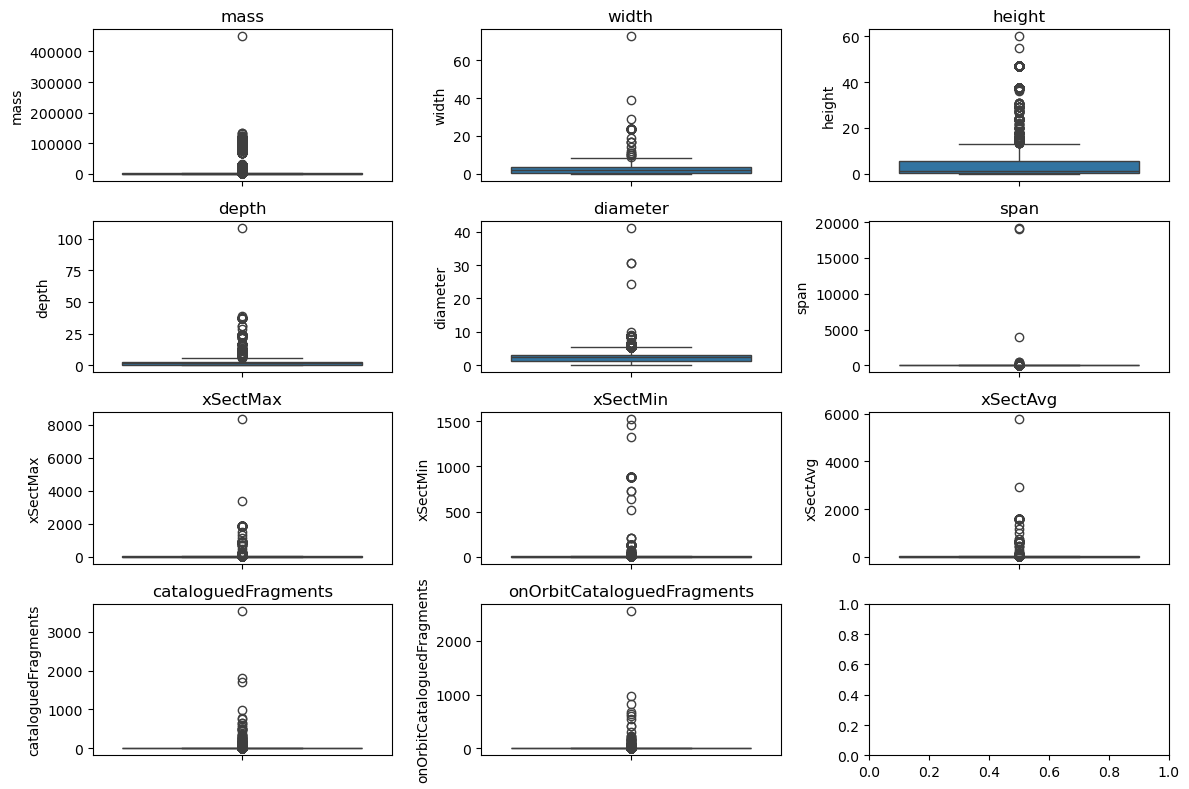

In [108]:
# Create a list of numeric columns to plot
numeric_cols = ['mass', 'width', 'height', 'depth', 'diameter', 'span', 'xSectMax', 'xSectMin','xSectAvg', 
                'cataloguedFragments', 'onOrbitCataloguedFragments']

# Set up the matplotlib grid
fig, axes = plt.subplots(4, 3, figsize=(12, 8))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()




There are a lot of outliers that will need to be handled appropriately.  Catalogued fragments for instance, these features contain a lot of 0 values because most objects don't have fragments associated with them.  But that means the outliers are real and valuable data that we don't want to be rid of.


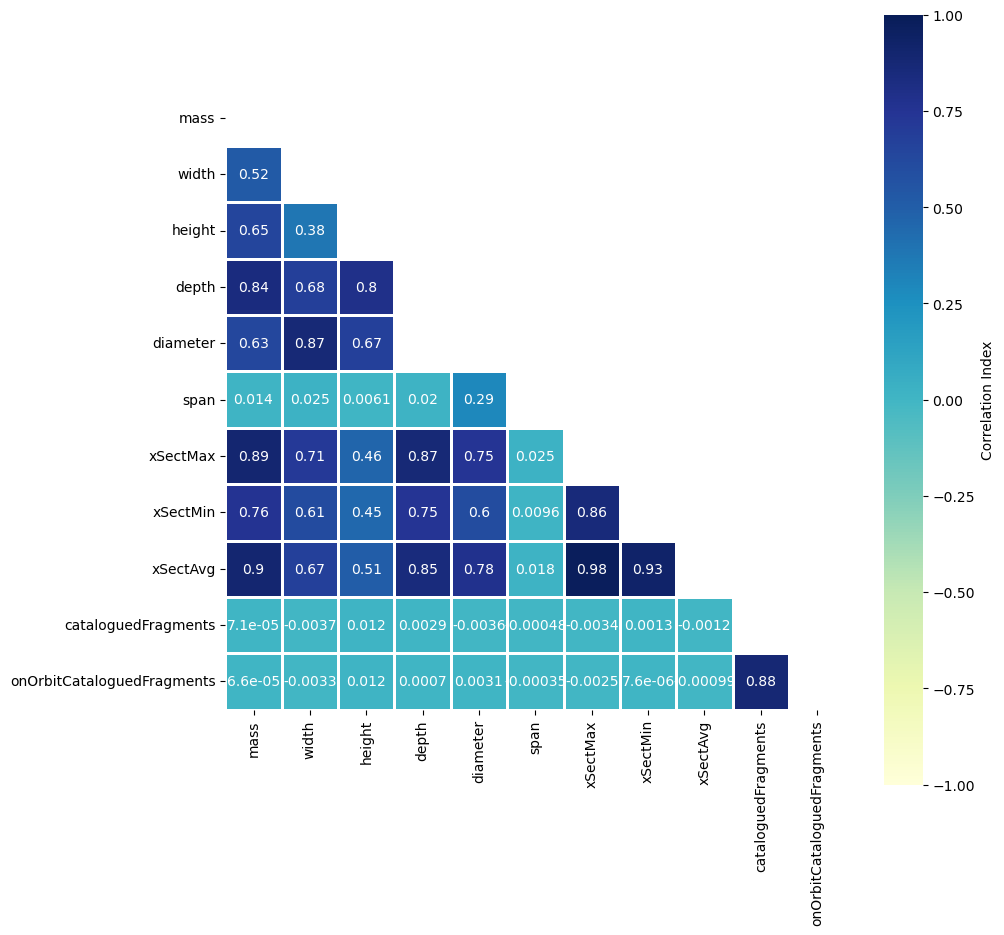

In [121]:
# Correlation plot for numerical columns

matrix = np.triu(df[numeric_cols].corr())

plt.figure(figsize=(10,10))
# parse corr variable intro triangular matrix
sns.heatmap(df[numeric_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot=True,
            cmap = 'YlGnBu',
            linewidths = .75,
            mask = matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'})
plt.show()


Lot of overlap with Xsect and volume features.  Same with catalogued fragments, something to consider when it comes time for modeling


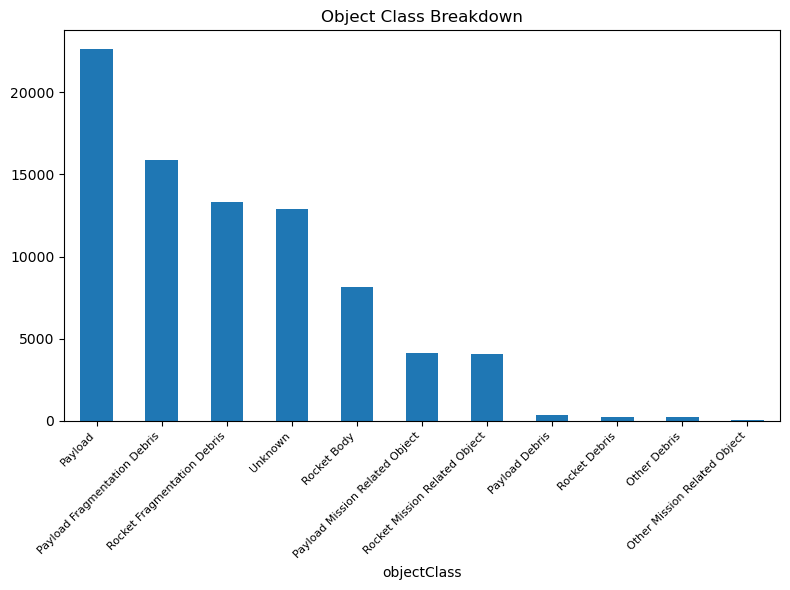

In [107]:
import matplotlib.pyplot as plt
import textwrap

plt.figure(figsize = (8, 6))

ax = df['objectClass'].value_counts().plot(kind='bar', title="Object Class Breakdown")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

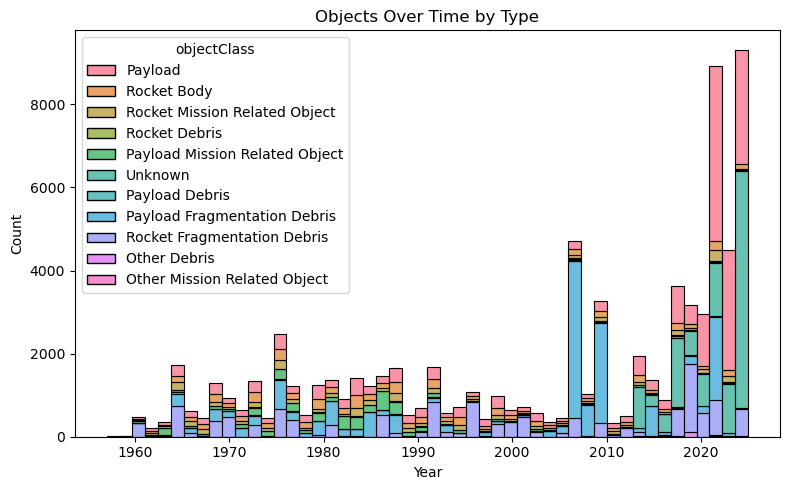

In [75]:
# Ploting object frequency by year
df['firstEpoch'] = pd.to_datetime(df['firstEpoch'])

# Drop rows with invalid dates (NaT)
df = df.dropna(subset=['firstEpoch'])

df['year'] = df['firstEpoch'].dt.year
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='year', hue='objectClass', multiple='stack', bins=50)
plt.title("Objects Over Time by Type")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Huge growth in payloads


<Axes: xlabel='firstEpoch'>

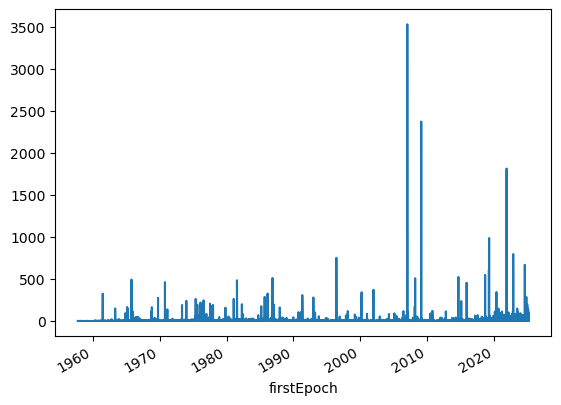

In [18]:
df['firstEpoch'] = pd.to_datetime(df['firstEpoch'])

df['firstEpoch'].value_counts().sort_index().plot(x = 'firstEpoch', kind = 'line')



Steady amount of launches with large uptick beginning in the 2000's


 **Missing Values**

In [19]:
df.isna().sum()


cosparId                      14275
vimpelId                      67008
satno                         18889
name                          14551
objectClass                       0
mass                          47891
shape                         48706
width                         63511
height                        49261
depth                         63538
diameter                      67132
span                          49561
xSectMax                      48961
xSectMin                      48961
xSectAvg                      49021
firstEpoch                     4104
mission                       59226
predDecayDate                 42464
active                        70418
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64


Most columns have missing values, we'll have to take each one by one and see the best way to handle them.  


## Lost objects

In [29]:
df = pd.read_csv(f's3://{raw_prefix}lost_objects_folder/lost_objects.csv')

In [30]:
df.shape


(2582, 8)

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NORAD Catalog Number,2581.0,37683.10926,9123.180388,52.0,32164.0,38024.0,43545.0,62905.0



No numerical values present, might be able to fill that in by joining the other datasets


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582 entries, 0 to 2581
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   International Designator  2582 non-null   object 
 1   NORAD Catalog Number      2581 non-null   float64
 2   Satellite Name            2581 non-null   object 
 3   Source                    2581 non-null   object 
 4   Launch Date               2581 non-null   object 
 5   Launch Site               2581 non-null   object 
 6   Object Type               2581 non-null   object 
 7   Last Data                 2581 non-null   object 
dtypes: float64(1), object(7)
memory usage: 161.5+ KB



Seems like one missing value, and mostly object data, some of which can be converted to datetimes


In [33]:
df['Launch Site'].value_counts()


Launch Site
TYMSC    682
TAISC    614
PLMSC    469
AFETR    325
AFWTR    201
XICLF    112
FRGUI    107
WLPIS     26
SRILR     25
TANSC      4
JSC        4
SEAL       3
KSCUT      2
KWAJ       2
RLLB       2
DLS        1
ERAS       1
WSC        1
Name: count, dtype: int64

<Axes: xlabel='Source'>

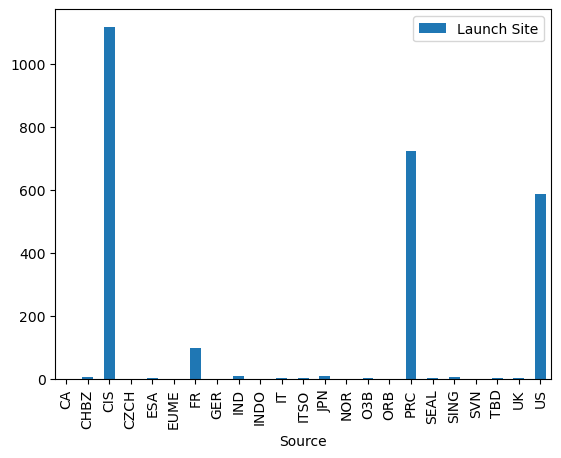

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

df[['Launch Site', 'Source']].groupby('Source').count().plot(kind = 'bar')



Handful of places responsible for most of the lost objects


[04/09/25 17:39:37] INFO     Using categorical units to plot a list of strings that are all         ]8;id=729603;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=178042;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=987063;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=393500;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

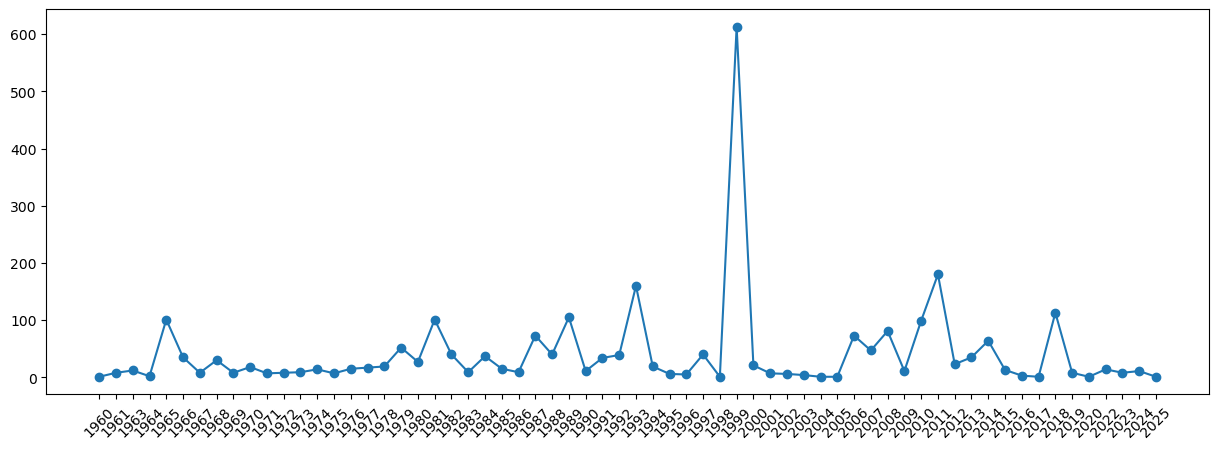

In [35]:
df['Launch Date'] = pd.to_datetime(df['Launch Date'])
launch_counts = df.groupby(df['Launch Date'].dt.to_period("Y"))['International Designator'].count()

launch_counts.index = launch_counts.index.astype(str)

plt.figure(figsize = (15,5))

plt.plot(launch_counts.index, launch_counts.values, marker = 'o', linestyle = '-')

plt.xticks(rotation = 45)

plt.show()



Large spike of missing objects from the late 1990's for some reason


In [36]:
df['Object Type'].value_counts()


Object Type
DEB     2492
PAY-      37
R/B       25
PAY+      25
UNK        2
Name: count, dtype: int64


Mostly Debris objects that are missing.  Makes sense, but also important to track these objects


## Satcat

In [123]:
df = pd.read_csv(f"s3://{raw_prefix}satcat_folder/full_satcat.csv")

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,63073.0,31536.000000,18207.751101,0.0000,15768.0000,31536.0000,47304.00000,63072.00
NORAD_CAT_ID,63073.0,31545.884990,18220.553000,1.0000,15769.0000,31537.0000,47305.00000,63155.00
PERIOD,62165.0,179.444980,693.984559,0.0000,89.2800,94.1100,101.26000,95687.68
INCLINATION,62165.0,69.073459,25.092792,0.0000,53.0300,70.3800,95.38000,153.72
APOGEE,62165.0,3604.447519,14008.818079,0.0000,268.0000,491.0000,885.00000,641287.00
PERIGEE,62165.0,1756.687815,6728.001806,0.0000,197.0000,413.0000,681.00000,289265.00
RCS,32931.0,3.662501,19.296260,0.0001,0.0137,0.0647,1.09135,928.31


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63073 entries, 0 to 63072
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        63073 non-null  int64  
 1   OBJECT_NAME       63073 non-null  object 
 2   OBJECT_ID         63073 non-null  object 
 3   NORAD_CAT_ID      63073 non-null  int64  
 4   OBJECT_TYPE       63073 non-null  object 
 5   OPS_STATUS_CODE   45825 non-null  object 
 6   OWNER             63073 non-null  object 
 7   LAUNCH_DATE       63073 non-null  object 
 8   LAUNCH_SITE       63073 non-null  object 
 9   DECAY_DATE        32937 non-null  object 
 10  PERIOD            62165 non-null  float64
 11  INCLINATION       62165 non-null  float64
 12  APOGEE            62165 non-null  float64
 13  PERIGEE           62165 non-null  float64
 14  RCS               32931 non-null  float64
 15  DATA_STATUS_CODE  1171 non-null   object 
 16  ORBIT_CENTER      63073 non-null  object

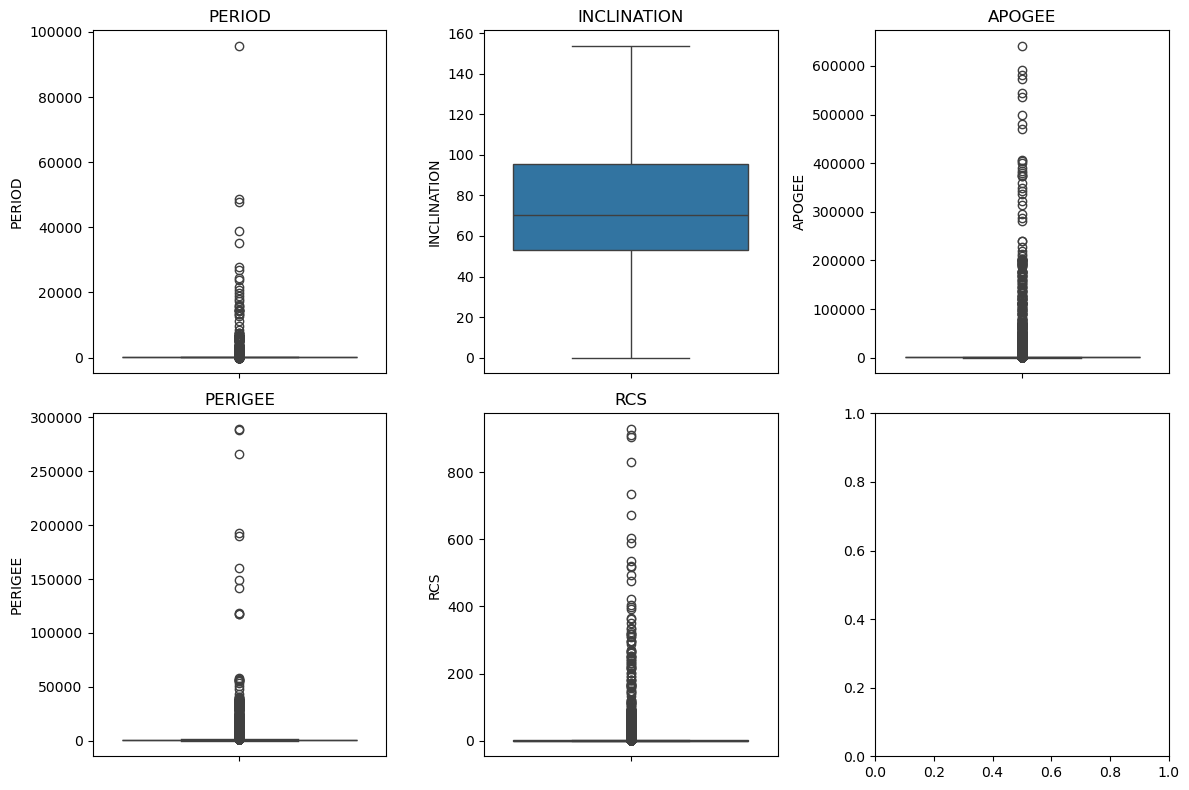

In [124]:
# Create a list of numeric columns to plot
numeric_cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE', 'RCS']

# Set up the matplotlib grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


Lot of outliers except for inclination.  Very few missing values for these features as well, so need to explore that more deeply


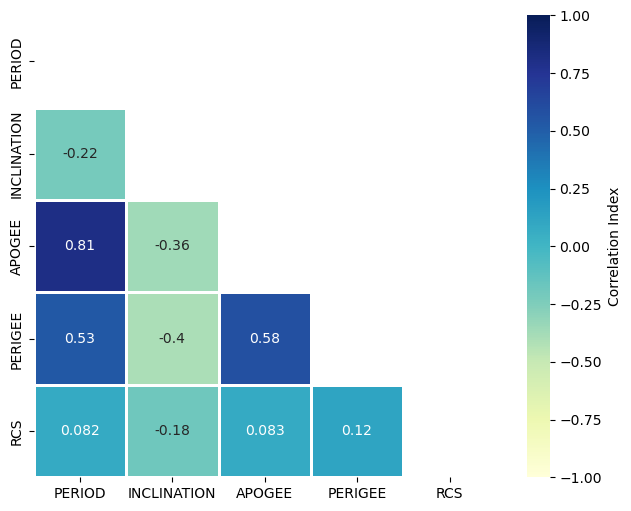

In [128]:
# Check for correlations

matrix = np.triu(df[numeric_cols].corr())

plt.figure(figsize=(8,6))
# parse corr variable intro triangular matrix
sns.heatmap(df[numeric_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot=True,
            linewidths = .75,
            cmap="YlGnBu",
            mask = matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'})
plt.show()

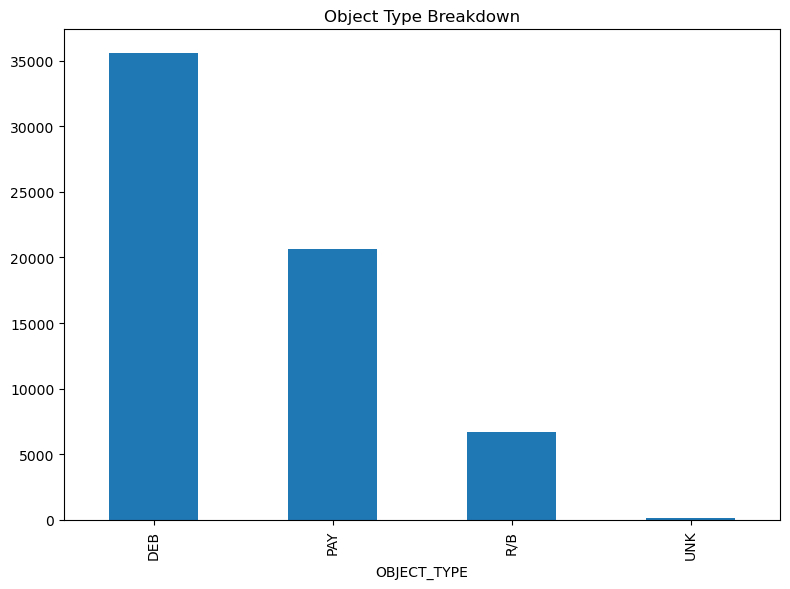

In [44]:
plt.figure(figsize = (8, 6))

ax = df['OBJECT_TYPE'].value_counts().plot(kind='bar', title="Object Type Breakdown")
plt.tight_layout()
plt.show()


Most objects classified as debris


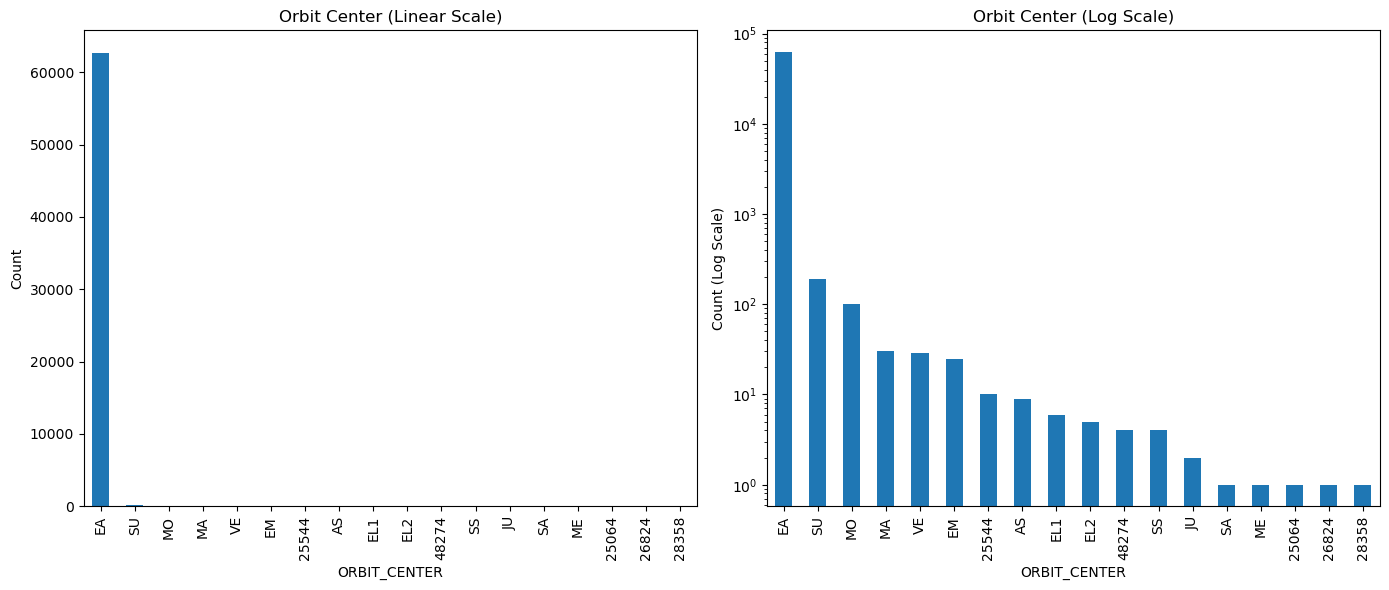

In [49]:
orbit_counts = df['ORBIT_CENTER'].value_counts()

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot with linear scale
orbit_counts.plot(kind='bar', ax=axes[0], title="Orbit Center (Linear Scale)")
axes[0].set_ylabel("Count")

# Plot with log scale
orbit_counts.plot(kind='bar', ax=axes[1], title="Orbit Center (Log Scale)")
axes[1].set_yscale('log')
axes[1].set_ylabel("Count (Log Scale)")

plt.tight_layout()
plt.show()


Clearly most objects orbit around Earth, and that's all we're interested in anyway


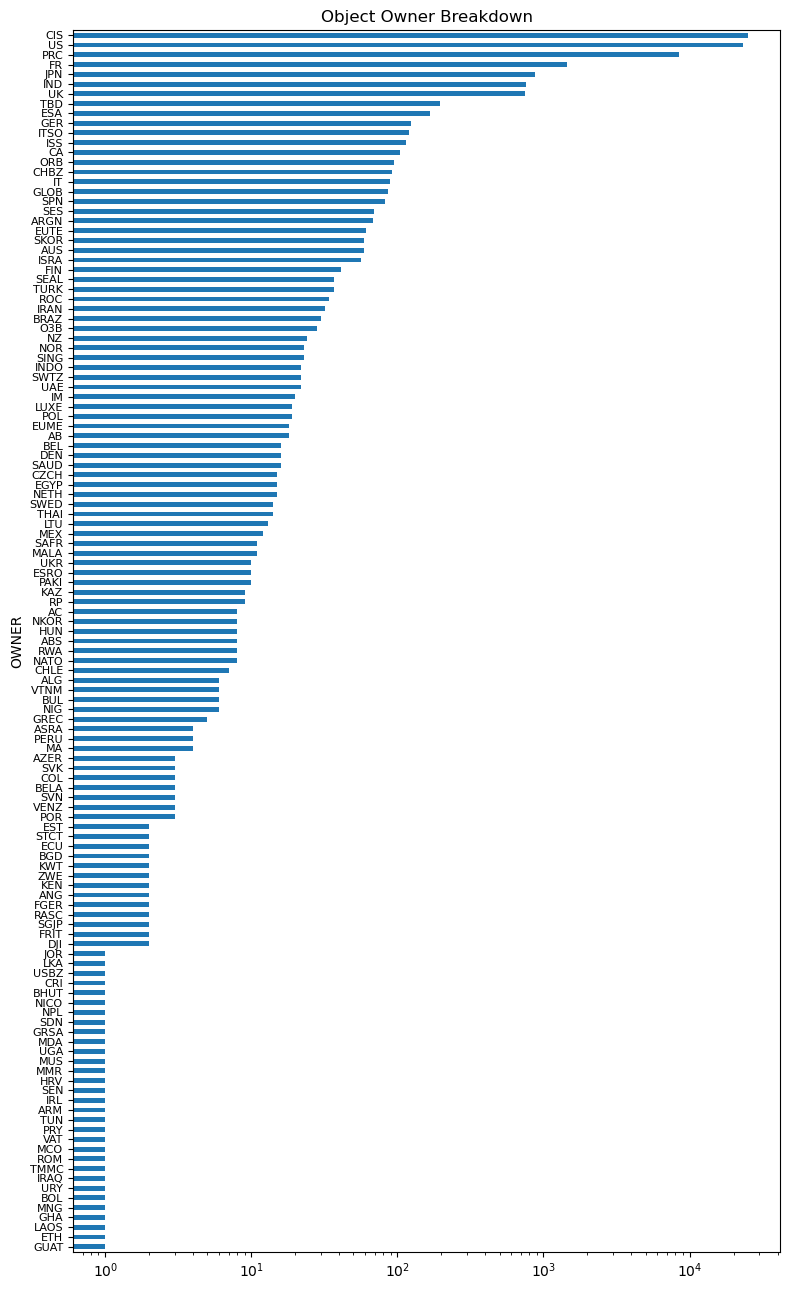

In [68]:
plt.figure(figsize = (8, 13))

owner_counts = df['OWNER'].value_counts().sort_values(ascending=True)

ax = owner_counts.plot(kind='barh', title="Object Owner Breakdown")
plt.yticks(fontsize=8)
ax.set_xscale('log')
plt.tight_layout()
plt.show()

## Collision data

In [130]:
df = pd.read_csv(f's3://{raw_prefix}simplified_collision_folder/simplified_collision_data.csv')

In [77]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NORAD_CAT_ID_1,80377.0,51131.009891,8280.424098,9.000000e+02,4.508500e+04,53168.000000,57794.000000,63153.0000
DSE_1,80377.0,4.001929,2.098845,9.800000e-02,2.231000e+00,3.990000,5.752000,21.6620
NORAD_CAT_ID_2,80377.0,47026.891648,22309.677971,5.000000e+00,3.447300e+04,53286.000000,60239.000000,270438.0000
DSE_2,80377.0,4.248234,2.296182,8.400000e-02,2.403000e+00,4.193000,5.967000,31.6690
TCA_RANGE,80377.0,3.316635,1.193988,1.800000e-02,2.474000e+00,3.522000,4.324000,5.0000
TCA_RELATIVE_SPEED,80377.0,11.247789,3.776045,0.000000e+00,8.786000e+00,12.656000,14.328000,16.5350
MAX_PROB,80377.0,0.000041,0.001044,2.417000e-08,5.822000e-07,0.000005,0.000011,0.2438
DILUTION,80377.0,1.368719,0.702543,5.000000e-03,8.660000e-01,1.244000,1.806000,3.5280


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80377 entries, 0 to 80376
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NORAD_CAT_ID_1      80377 non-null  int64  
 1   OBJECT_NAME_1       80377 non-null  object 
 2   DSE_1               80377 non-null  float64
 3   NORAD_CAT_ID_2      80377 non-null  int64  
 4   OBJECT_NAME_2       80377 non-null  object 
 5   DSE_2               80377 non-null  float64
 6   TCA                 80377 non-null  object 
 7   TCA_RANGE           80377 non-null  float64
 8   TCA_RELATIVE_SPEED  80377 non-null  float64
 9   MAX_PROB            80377 non-null  float64
 10  DILUTION            80377 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 6.7+ MB



No missing values to worry about


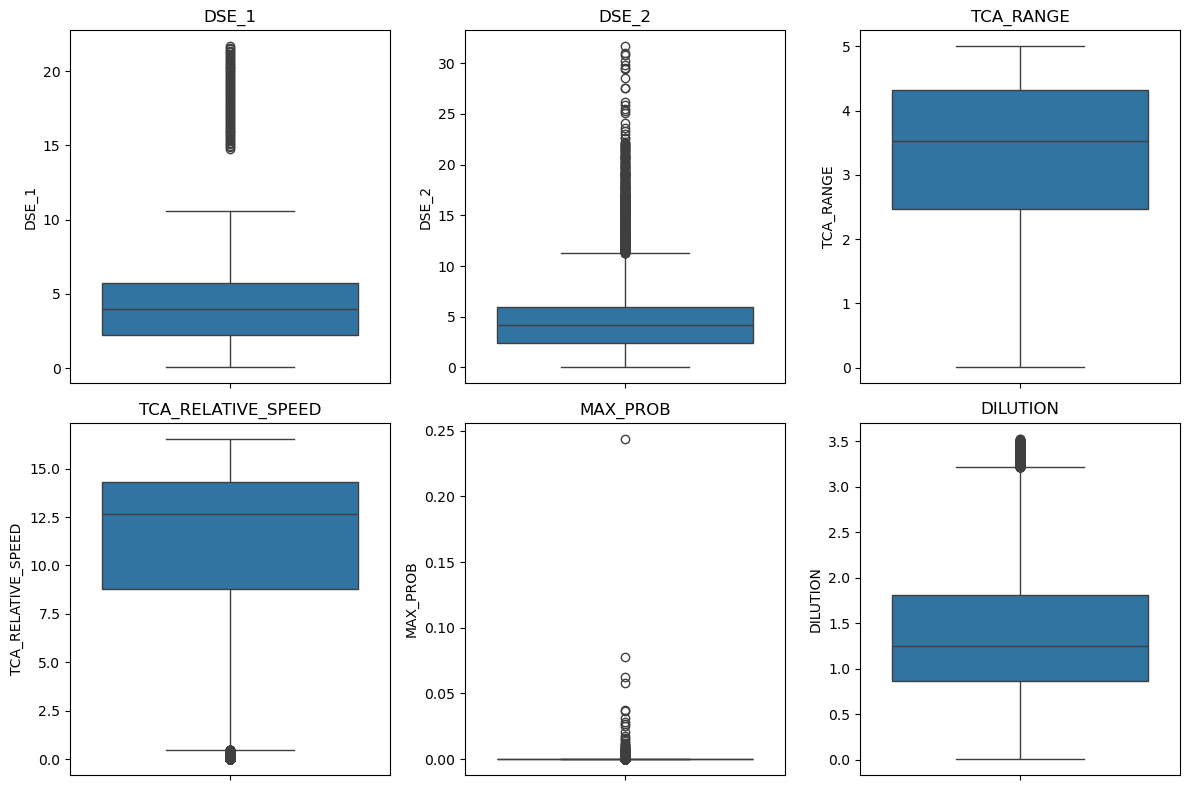

In [131]:
# Check for outliers

numeric_cols = ['DSE_1', 'DSE_2', 'TCA_RANGE', 'TCA_RELATIVE_SPEED', 'MAX_PROB', 'DILUTION']

# Set up the matplotlib grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x2 grid

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


Handful of outliers to consider


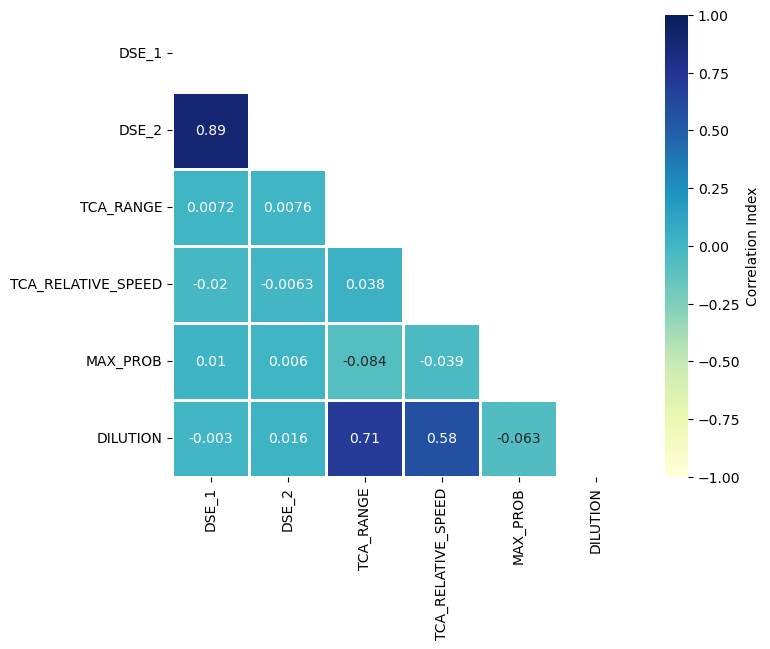

In [132]:
# Let's see how they correlate

matrix = np.triu(df[numeric_cols].corr())

plt.figure(figsize=(8, 6))
# parse corr variable intro triangular matrix
sns.heatmap(df[numeric_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot=True,
            linewidths = .75,
            cmap="YlGnBu",
            mask = matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'})
plt.show()


Low correlation among most, high among the DSE features and dilution and TCA


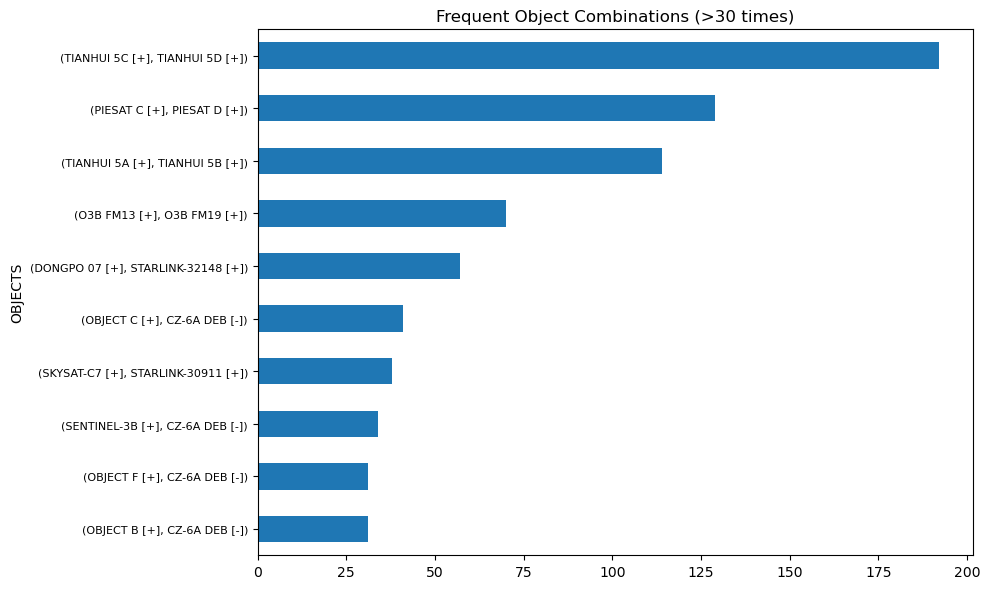

In [91]:
# Plot showing the objects with the most number of near collisions

combo_counts = df[['OBJECT_NAME_1', 'OBJECT_NAME_2']].value_counts()
filtered_combo_counts = combo_counts[combo_counts > 30].sort_values(ascending = True)

# Plot
plt.figure(figsize=(10, 6))
filtered_combo_counts.plot(kind='barh', title='Frequent Object Combinations (>30 times)')
plt.yticks(fontsize = 8)
plt.ylabel('OBJECTS')
plt.tight_layout()
plt.show()

# Clean/Transform

## ESA Data

In [133]:
esa_df = pd.read_parquet(f"s3://{bucket}/data/raw_data/full_esa_folder/full_esa_data.parquet")


In [134]:
# Columns with too many missing values or not useful for modeling

columns_to_drop = ['vimpelId', 'satno', 'predDecayDate', 'active', 'mission', 'shape', 'mass', 'width', 'height', 'depth', 'xSectMax', 'xSectMin']


In [135]:
# Drop columns and check missing values again

esa_df.drop(columns = columns_to_drop, inplace = True)

esa_df.isna().sum()


cosparId                      14275
name                          14551
objectClass                       0
diameter                      67132
span                          49561
xSectAvg                      49021
firstEpoch                     4104
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [136]:
# Change to Date time

esa_df['firstEpoch'] = pd.to_datetime(esa_df['firstEpoch'])


In [137]:
# Lot of rows are all NA or 0, but have positive values for first Epoch, so removing those

exclude_col = ['firstEpoch', 'objectClass']

# Drop rows where all values (except the exclude_col) are NA or 0
esa_df = esa_df[~((esa_df.drop(columns=exclude_col).isna()) | (esa_df.drop(columns=exclude_col) == 0)).all(axis=1)]

esa_df.isna().sum()


cosparId                        458
name                            734
objectClass                       0
diameter                      53315
span                          35744
xSectAvg                      35204
firstEpoch                     4073
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [138]:
# Name and object class are still necessary, so if both are null then remove, otherwise keep and deal with the other missing data as needed

esa_df_cleaned = esa_df[~esa_df[['cosparId', 'name']].isna().all(axis = 1)]

esa_df_cleaned.isna().sum()


cosparId                        458
name                            734
objectClass                       0
diameter                      53315
span                          35744
xSectAvg                      35204
firstEpoch                     4073
cataloguedFragments               0
onOrbitCataloguedFragments        0
dtype: int64

In [193]:
# Save this esa dataframe separately to graph object class for Goal # 1 before further processing for modeling

esa_df_cleaned.to_parquet(f"{current_path}/data/processed data/cleaned_esa_goal1.parquet", index = False)
esa_df_cleaned.to_parquet(f"s3://{bucket}/data/processed_data/esa_goal1_folder/cleaned_esa_goal1.parquet", index = False)


In [143]:
# Make a copy and collapse objectClass category into 4 values

esa_df_modeling = esa_df_cleaned.copy()

esa_df_modeling['objectClass'] = esa_df_modeling['objectClass'].apply(lambda x: 'Debris' if 'Debris' in x else x)
esa_df_modeling.loc[esa_df_modeling['objectClass'].str.contains('Mission'), 'objectClass'] = 'Debris'


In [144]:
esa_df_modeling.columns


Index(['cosparId', 'name', 'objectClass', 'diameter', 'span', 'xSectAvg',
       'firstEpoch', 'cataloguedFragments', 'onOrbitCataloguedFragments'],
      dtype='object')

In [145]:
# Standardize the numerical features and save

standard_cols = ['diameter', 'span', 'xSectAvg', 'cataloguedFragments', 'onOrbitCataloguedFragments']

esa_df_modeling[['diameter', 'span', 'xSectAvg']] = esa_df_modeling[['diameter', 'span', 'xSectAvg']].apply(lambda x: x.fillna(x.median()))

esa_df_modeling[standard_cols] = esa_df_modeling[standard_cols].apply(zscore)


In [146]:
# Rename columns for consistency

esa_df_modeling.rename(columns = {
    'cosparId': 'object_id',
    'name': 'object_name',
    'objectClass': 'object_type',
    'firstEpoch': 'launch_date'
},
                      inplace = True)


In [147]:
# Standardize column names
esa_df_modeling.columns = esa_df_modeling.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", esa_df_modeling.columns)


Updated Column Names:
 Index(['object_id', 'object_name', 'object_type', 'diameter', 'span',
       'xsectavg', 'launch_date', 'cataloguedfragments',
       'onorbitcataloguedfragments'],
      dtype='object')


In [148]:
esa_df_modeling.to_parquet(f"{current_path}/data/processed data/esa_df_modeling.parquet", index = False)
esa_df_modeling.to_parquet(f"s3://{bucket}/data/processed_data/esa_folder/esa_df_modeling.parquet", index = False)


## Satcat

In [149]:
satcat_df = pd.read_csv(f"s3://{bucket}/data/raw_data/satcat_folder/full_satcat.csv")


In [150]:
# Check for missing values

missing_values = satcat_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Unnamed: 0              0
OBJECT_NAME             0
OBJECT_ID               0
NORAD_CAT_ID            0
OBJECT_TYPE             0
OPS_STATUS_CODE     17248
OWNER                   0
LAUNCH_DATE             0
LAUNCH_SITE             0
DECAY_DATE          30136
PERIOD                908
INCLINATION           908
APOGEE                908
PERIGEE               908
RCS                 30142
DATA_STATUS_CODE    61902
ORBIT_CENTER            0
ORBIT_TYPE              0
dtype: int64


In [151]:
# Check unique values per column

unique_counts = satcat_df.nunique().sort_values()
print("Unique Values per Column:\n", unique_counts)


Unique Values per Column:
 DATA_STATUS_CODE        3
OBJECT_TYPE             4
ORBIT_TYPE              4
OPS_STATUS_CODE         7
ORBIT_CENTER           18
LAUNCH_SITE            36
OWNER                 125
PERIGEE              3719
LAUNCH_DATE          5644
APOGEE               6658
INCLINATION          6800
PERIOD               8261
RCS                 10800
DECAY_DATE          14562
OBJECT_NAME         22276
OBJECT_ID           63073
Unnamed: 0          63073
NORAD_CAT_ID        63073
dtype: int64


In [152]:
# Drop uneccessary columns

columns_to_drop = ['Unnamed: 0', 'DATA_STATUS_CODE', 'RCS', 'OPS_STATUS_CODE', 'DATA_STATUS_CODE']
satcat_df = satcat_df.drop(columns = columns_to_drop)

# Only concerned with objects in orbit around Earth, so remove all others

satcat_df = satcat_df[satcat_df['ORBIT_CENTER'] == 'EA']
satcat_df = satcat_df.drop(columns = 'ORBIT_CENTER')


In [153]:
# Change names of orbit type to be consistent with others

satcat_df['OBJECT_TYPE'] = satcat_df['OBJECT_TYPE'].replace({
    'DEB': 'DEBRIS',
    'PAY': 'PAYLOAD',
    'R/B': 'ROCKET BODY',
    'UNK': 'UNKNOWN'
})

satcat_df['NORAD_CAT_ID'] = satcat_df['NORAD_CAT_ID'].astype('str')


In [154]:
# Fill in some of the NA values for the distance and location metrics.  If orbit type is IMP or LAN that means they're no longer in orbit

satcat_df.loc[(satcat_df['ORBIT_TYPE'] == 'IMP') | (satcat_df['ORBIT_TYPE'] == 'LAN'), ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']] = 0

# If still in orbit, impute the median (to adjust for outliers)

cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']
satcat_df[cols] = satcat_df[cols].fillna(satcat_df[satcat_df['ORBIT_TYPE'] == 'ORB'][cols].median())


In [155]:
# Create new columns called Has Decayed so Decay Dates can be kept

satcat_df['HAS_DECAYED'] = satcat_df['DECAY_DATE'].notna().astype(int)


In [156]:
# Standardize column names

satcat_df.columns = satcat_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", satcat_df.columns)


Updated Column Names:
 Index(['object_name', 'object_id', 'norad_cat_id', 'object_type', 'owner',
       'launch_date', 'launch_site', 'decay_date', 'period', 'inclination',
       'apogee', 'perigee', 'orbit_type', 'has_decayed'],
      dtype='object')


In [157]:
# Convert date columns 

date_columns = ["launch_date", 'decay_date']  
for col in date_columns:
    if col in satcat_df.columns:
        satcat_df[col] = pd.to_datetime(satcat_df[col], errors="coerce")

# Convert categorical columns

categorical_cols = satcat_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    satcat_df[col] = satcat_df[col].astype("category")

# Check data types after conversion
satcat_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 62652 entries, 0 to 63072
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   object_name   62652 non-null  category      
 1   object_id     62652 non-null  category      
 2   norad_cat_id  62652 non-null  category      
 3   object_type   62652 non-null  category      
 4   owner         62652 non-null  category      
 5   launch_date   62652 non-null  datetime64[ns]
 6   launch_site   62652 non-null  category      
 7   decay_date    32824 non-null  datetime64[ns]
 8   period        62652 non-null  float64       
 9   inclination   62652 non-null  float64       
 10  apogee        62652 non-null  float64       
 11  perigee       62652 non-null  float64       
 12  orbit_type    62652 non-null  category      
 13  has_decayed   62652 non-null  int64         
dtypes: category(7), datetime64[ns](2), float64(4), int64(1)
memory usage: 10.3 MB


In [158]:
# Save

satcat_df.to_parquet(f"{current_path}/data/processed data/satcat_df.parquet", index = False)
satcat_df.to_parquet(f"s3://{bucket}/data/processed_data/satcat_folder/satcat_df.parquet", index = False)


## Leo Objects

In [159]:
leo_df = pd.read_csv(f"s3://{bucket}/data/raw_data/leo_objects_folder/leo_objects.csv")


In [160]:
# Drop columns that are repeat columns or unecessary for modeling

columns_to_drop = ['Unnamed: 0', 'DECAY', 'COMMENT', 'COMMENTCODE', 'FILE', 'LAUNCH_YEAR', 'LAUNCH_PIECE', 'LAUNCH_NUM', 'RCSVALUE', 
                   'OBJECT_NUMBER', 'OBJECT_ID', 'OBJECT_NAME', 'CURRENT']

leo_df = leo_df.drop(columns = columns_to_drop)


In [161]:
# Change norad cat id from int to string and change launch to date value

leo_df['NORAD_CAT_ID'] = leo_df['NORAD_CAT_ID'].astype('str')
leo_df['LAUNCH'] = pd.to_datetime(leo_df['LAUNCH'])


In [162]:
# Fill NA of RCS SIZE with distribution of corresponding object type

leo_df[(leo_df['OBJECT_TYPE'] == 'UNKNOWN') & (leo_df['RCS_SIZE'].notna())]['RCS_SIZE'].value_counts()


RCS_SIZE
MEDIUM    303
SMALL     179
LARGE      99
Name: count, dtype: int64

In [163]:
# Standardize numerical columns

leo_df_standardize = leo_df.copy()

numerical_cols = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']

leo_df_standardize[numerical_cols] = leo_df_standardize[numerical_cols].apply(zscore)


In [164]:
# Convert categorical columns

categorical_cols = leo_df_standardize.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    leo_df_standardize[col] = leo_df_standardize[col].astype("category")


In [165]:
# Rename columns for consistency

leo_df_standardize.rename(columns = {
    'INTLDES': 'object_id',
    'SATNAME': 'object_name',
    'SITE': 'launch_site',
    'LAUNCH': 'launch_date'
},
             inplace = True)


In [166]:
# Standardize column names

leo_df_standardize.columns = leo_df_standardize.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", leo_df_standardize.columns)


Updated Column Names:
 Index(['object_id', 'norad_cat_id', 'object_type', 'object_name', 'country',
       'launch_date', 'launch_site', 'period', 'inclination', 'apogee',
       'perigee', 'rcs_size'],
      dtype='object')


In [167]:
# Save

leo_df_standardize.to_parquet(f"{current_path}/data/processed data/leo_objects.parquet", index = False)
leo_df_standardize.to_parquet(f"s3://{bucket}/data/processed_data/leo_objects_folder/leo_objects.parquet", index = False)


## Collision Data

In [113]:
collision_df = pd.read_csv(f"s3://{bucket}/data/raw_data/simplified_collision_folder/simplified_collision_data.csv")


In [114]:
# Change data types

collision_df[['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']] = collision_df[['NORAD_CAT_ID_1', 'NORAD_CAT_ID_2']].astype('category')

collision_df['TCA'] = pd.to_datetime(collision_df['TCA'])


In [115]:
# Standardize numerical columns

num_cols = ['DSE_1', 'DSE_2', 'TCA_RANGE', 'TCA_RELATIVE_SPEED', 'DILUTION']
collision_df[num_cols] = collision_df[num_cols].apply(zscore)


In [116]:
# Extract activity status from object and create new column

def extract_status(obj_name):
    """Extracts activity status and cleans the object name."""
    obj_name = str(obj_name)  # Ensure string type for parsing
    is_active = 1 if "[+]" in obj_name else 0
    cleaned_name = re.sub(r"[\[\]\+\-]", "", obj_name).strip()  # Remove [+] and [-]
    return cleaned_name, is_active

# Apply extraction function to both object columns
collision_df[['OBJECT_NAME_1_Clean', 'OBJECT_1_Active']] = collision_df['OBJECT_NAME_1'].apply(lambda x: pd.Series(extract_status(x)))
collision_df[['OBJECT_NAME_2_Clean', 'OBJECT_2_Active']] = collision_df['OBJECT_NAME_2'].apply(lambda x: pd.Series(extract_status(x)))

# Create Activity_Status column based on activity status
collision_df['Activity_Status'] = collision_df['OBJECT_1_Active'] + (collision_df['OBJECT_2_Active'] * 2)

# Drop original object columns and rename cleaned ones
collision_df = collision_df.drop(columns=['OBJECT_NAME_1', 'OBJECT_NAME_2'])
collision_df = collision_df.rename(columns={'OBJECT_NAME_1_Clean': 'OBJECT_NAME_1', 'OBJECT_NAME_2_Clean': 'OBJECT_NAME_2'})

# Standardize column names
collision_df.columns = collision_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", collision_df.columns)

# Change activity status to category

collision_df['activity_status'] = collision_df['activity_status'].astype('category')


Updated Column Names:
 Index(['norad_cat_id_1', 'dse_1', 'norad_cat_id_2', 'dse_2', 'tca',
       'tca_range', 'tca_relative_speed', 'max_prob', 'dilution',
       'object_name_1', 'object_1_active', 'object_name_2', 'object_2_active',
       'activity_status'],
      dtype='object')


In [117]:
# Save

collision_df.to_parquet(f"{current_path}/data/processed data/collision_data.parquet", index=False)
collision_df.to_parquet(f"s3://{bucket}/data/processed_data/collision_data_folder/collision_data.parquet", index = False)


## Lost Object

In [173]:
lost_df = pd.read_csv(f"s3://{bucket}/data/raw_data/lost_objects_folder/lost_objects.csv")


In [174]:
# Drop last row, artifact from scraping data

lost_df = lost_df.iloc[:-1]


In [175]:
# Change data types appropriately and rename columns for consistency

lost_df['NORAD Catalog Number'] = lost_df['NORAD Catalog Number'].astype('category')
lost_df.rename(columns = {'NORAD Catalog Number': 'NORAD_CAT_ID', 'International Designator': 'object_id'}, inplace = True)
lost_df['Last Data'] = pd.to_datetime(lost_df['Last Data'], format='ISO8601', errors='coerce')
lost_df['Launch Date'] = pd.to_datetime(lost_df['Launch Date'])


In [176]:
# Change value names of object type column

lost_df['Object Type'] = lost_df['Object Type'].replace({
    'DEB': 'DEBRIS',
    'PAY-': 'PAYLOAD',
    'PAY+': 'PAYLOAD',
    'R/B': 'ROCKET BODY',
    'UNK': 'UNKNOWN'
})


In [177]:
# Standardize column names
lost_df.columns = lost_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("Updated Column Names:\n", lost_df.columns)


Updated Column Names:
 Index(['object_id', 'norad_cat_id', 'satellite_name', 'source', 'launch_date',
       'launch_site', 'object_type', 'last_data'],
      dtype='object')


In [178]:
# Save

lost_df.to_parquet(f"{current_path}/data/processed data/lost_objects.parquet", index = False)
lost_df.to_parquet(f"s3://{bucket}/data/processed_data/lost_object_folder/lost_objects.parquet", index = False)

# Bias exploration


Satcat data is used most often, so we'll explore the biases in the object_type and orbit_type features


In [45]:
df = pd.read_parquet(f"{current_path}/data/processed data/satcat_df.parquet")


We'll look at the bias of object types among different values of orbit type, using debris as the positive label considering debris objects are of the most interest for our stated goals


In [56]:
facet_columns = report.FacetColumn(name = 'object_type')

label_column = report.LabelColumn(
    name = 'orbit_type',
    series = df['orbit_type'],
    positive_label_values=['ORB']
)

## Generate bias report

- Using metrics most useful for exploring pre-training bias (Class imbalance, difference in positive label proportions and Jensen-Shannon divergence)

In [57]:
report.bias_report(
    df = df,
    facet_column=facet_columns,
    label_column=label_column,
    stage_type=report.StageType.PRE_TRAINING,
    metrics=["CI", "DPL", "JS"]
)

[04/14/25 16:52:02] INFO     Column object_type with data uniqueness fraction 6.384472961757006e-05   ]8;id=980544;file:///opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/common.py\common.py]8;;\:]8;id=241972;file:///opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/common.py#150\150]8;;\
                             is classifed as a CATEGORICAL column                                                  

                    INFO     Column orbit_type with data uniqueness fraction 4.788354721317755e-05 is ]8;id=932981;file:///opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/common.py\common.py]8;;\:]8;id=88270;file:///opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/common.py#150\150]8;;\
                             classifed as a CATEGORICAL column                                                     

[{'value_or_threshold': 'ROCKET BODY',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.7915469577986337},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.14751402722345264},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.011229961367064521}]},
 {'value_or_threshold': 'PAYLOAD',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.3498371959394752},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': -0.33307504699198925},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.056839696089245745}]},
 {'value_or_threshold': 'DEBRIS',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': -0.13614888590946816},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'va

## Set up clarify processing job

In [63]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

[04/14/25 17:10:29] INFO     Ignoring unnecessary instance type: None.                            ]8;id=359598;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=72513;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [105]:
bias_report_output = "s3://{}/clarify-space".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=f"s3://{bucket}/data/processed_data/satcat_folder/satcat_df.csv",
    s3_output_path=bias_report_output,
    label="orbit_type",
    headers=df.columns.to_list(),
    dataset_type="text/csv",
)

In [102]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=['ORB'],
    facet_name="object_type",
    facet_values_or_threshold=["DEBRIS"],
)

## Run pre-training processing job

In [106]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods=["CI", "DPL", "JS"],
    wait=False,
    logs=False
)


run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

[04/14/25 17:50:32] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers':               ]8;id=177771;file:///opt/conda/lib/python3.11/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=404922;file:///opt/conda/lib/python3.11/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             ['object_name', 'object_id', 'norad_cat_id', 'object_type', 'owner',                  
                             'launch_date', 'launch_site', 'decay_date', 'period', 'inclination',                  
                             'apogee', 'perigee', 'orbit_type', 'has_decayed'], 'label':                           
                             'orbit_type', 'label_values_or_threshold': ['ORB'], 'facet':                          
                             [{'name_or_index': 'object_type', 'value_or_threshold': ['DEBRIS']}],                 
                             'methods': {'report': {'name': 'report', 'title': 'Analysis Report'},                 
                             'pre_training_bias': {'methods': ['CI', 'DPL', 'JS']}}}                               

                    INFO     Creating processing-job with name                                      ]8;id=444469;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=598948;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1575\1575]8;;\
                             Clarify-Pretraining-Bias-2025-04-14-17-50-32-213                                      

'Clarify-Pretraining-Bias-2025-04-14-17-50-32-213'

In [107]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-662949783070/data/processed_data/satcat_folder/satcat_df.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-662949783070/clarify-space/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-662949783070/clarify-space', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2025-04-14-17-50-32-213', 'Process

In [108]:
running_processor.wait(logs=False)

..........................................................!

## Download reports to workspace

In [109]:
!aws s3 cp --recursive $bias_report_output ./generated_bias_report/

download: s3://sagemaker-us-east-1-662949783070/clarify-space/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-662949783070/clarify-space/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-662949783070/clarify-space/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-662949783070/clarify-space/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-662949783070/clarify-space/report.html to generated_bias_report/report.html



Upon closer inspection, a class imbalance of -.136 indicates that Debris is fairly represented among objects in orbit and a JS of .029 indicates distribution of orbit types among debris is similar to the other object types

The Unknown class is underrepresented and other datasets might have an imbalance so we'll handle rebalancing separately in case it's needed for modeling


# Athena Tables

## Create variable paths and store them

In [179]:
esa_path = "s3://{}/data/processed_data/esa_folder/".format(bucket)
leo_path = "s3://{}/data/processed_data/leo_objects_folder/".format(bucket)
lost_path = "s3://{}/data/processed_data/lost_object_folder/".format(bucket)
satcat_path = "s3://{}/data/processed_data/satcat_folder/".format(bucket)
collision_path = "s3://{}/data/processed_data/collision_data_folder/".format(bucket)


In [180]:
%store esa_path
%store leo_path
%store lost_path
%store satcat_path
%store collision_path


Stored 'esa_path' (str)
Stored 'leo_path' (str)
Stored 'lost_path' (str)
Stored 'satcat_path' (str)
Stored 'collision_path' (str)


## Create tables names

In [181]:
table_name1 = "esa"
table_name2 = 'leo'
table_name3 = 'lost_objects'
table_name4 = 'satcat'
table_name5 = 'collision'


## Retrieve dataframes from directories

In [182]:
# Create filesystem object

fs = s3fs.S3FileSystem()

# Retrieve all files paths

parquet_paths = fs.find(f"{bucket}/data/processed_data/")

# Loop through and add to a list

dataframes = [pd.read_parquet(f"s3://{path}") for path in parquet_paths]

# Save each df to own variable

collision_df = dataframes[0]
esa_df = dataframes[2]
leo_df = dataframes[3]
lost_df = dataframes[4]
satcat_df = dataframes[5]


## Create staging directory path and initiate connection

In [183]:
s3_staging_dir = "s3://{}/athena/staging".format(bucket)


In [184]:
%store s3_staging_dir


Stored 's3_staging_dir' (str)


In [185]:
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)


## Check current databases

In [186]:
pd.read_sql("SHOW DATABASES", conn)


,database_name
0,default
1,sagemaker_featurestore
2,space_project


In [187]:
# Connect to project database

project_conn = connect(region_name = region, s3_staging_dir = s3_staging_dir, schema_name = 'space_project')


## Helper functions to generate table creation statements

In [188]:
def map_dtype_to_athena(dtype):
    dtype = str(dtype)
    if 'int' in dtype:
        return 'int'
    elif 'float' in dtype:
        return 'double'
    elif 'bool' in dtype:
        return 'boolean'
    elif 'datetime' in dtype:
        return 'timestamp'
    else:
        return 'string'  # default to string for object, category, etc.


In [189]:
def generate_athena_columns(df):
    cols = []
    for col in df.columns:
        athena_type = map_dtype_to_athena(df[col].dtype)
        cols.append(f"    {col} {athena_type}")
    return ",\n".join(cols)


In [190]:
def create_athena_table_statement(table_name, s3_path, df, database_name='space_project'):
    columns = generate_athena_columns(df)
    statement = f"""CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
{columns}
)
STORED AS PARQUET
LOCATION '{s3_path}'"""
    return statement


## Create table statement then test to make sure connection went through

In [194]:
esa_statement = create_athena_table_statement(table_name1, esa_path, esa_df)


In [195]:
pd.read_sql(esa_statement, project_conn)

pd.read_sql('SELECT * FROM esa LIMIT 5', project_conn)


,object_id,object_name,object_type,diameter,span,xsectavg,launch_date,cataloguedfragments,onorbitcataloguedfragments
0,1964-063C,Calsphere 1,Payload,-3.007907,-0.073223,-0.260538,1964-10-06,-0.021905,-0.016767
1,1964-063E,Calsphere 2,Payload,0.029411,-0.073223,-0.260538,1964-10-06,-0.021905,-0.016767
2,1965-034C,LCS 1,Payload,0.029411,-0.065878,-0.243743,1965-05-06,-0.021905,-0.016767
3,1965-065E,Tempsat 1,Payload,0.029411,-0.073223,-0.260538,1965-08-13,-0.021905,-0.016767
4,1965-065H,Calsphere 4,Payload,0.029411,-0.072842,-0.260092,1965-08-13,-0.021905,-0.016767


 ## Create other tables

In [196]:
collision_statement = create_athena_table_statement(table_name5, collision_path, collision_df)
leo_statement = create_athena_table_statement(table_name2, leo_path, leo_df)
lost_statement = create_athena_table_statement(table_name3, lost_path, lost_df)
satcat_statement = create_athena_table_statement(table_name4, satcat_path, satcat_df)

pd.read_sql(collision_statement, conn)
pd.read_sql(leo_statement, conn)
pd.read_sql(lost_statement, conn)
pd.read_sql(satcat_statement, conn)

""


## Check all tables were created

In [197]:
# Check all tables are there

pd.read_sql("SHOW TABLES", project_conn)

,tab_name
0,collision
1,esa
2,leo
3,lost_objects
4,satcat


# Goal 1

- Analyze the historic trends of debris growth

In [5]:
%store -r satcat_path

In [6]:
# Only need satcat data for this

df = pd.read_parquet(satcat_path)

In [9]:
#Subset the data frame by debris objects

debris_df  = df[df['object_type'] == 'DEBRIS']

In [12]:
# Create year only columns

debris_df['decay_year'] = debris_df['decay_date'].dt.year
debris_df['launch_year'] = debris_df['launch_date'].dt.year

In [16]:
# Aggregate the counts for launches and decay

launch_counts = debris_df['launch_year'].value_counts().sort_index()
decay_counts = debris_df['decay_year'].value_counts().sort_index()

In [17]:
# Create data frame of relevant data

years = range(debris_df["launch_year"].min(), pd.Timestamp.now().year + 1)
summary = pd.DataFrame(index=years)
summary["Debris_Added"] = launch_counts
summary["Debris_Decayed"] = decay_counts
summary = summary.fillna(0)

# Compute cumulative net debris
summary["Net_Change"] = summary["Debris_Added"] - summary["Debris_Decayed"]
summary["Cumulative_Debris"] = summary["Net_Change"].cumsum()

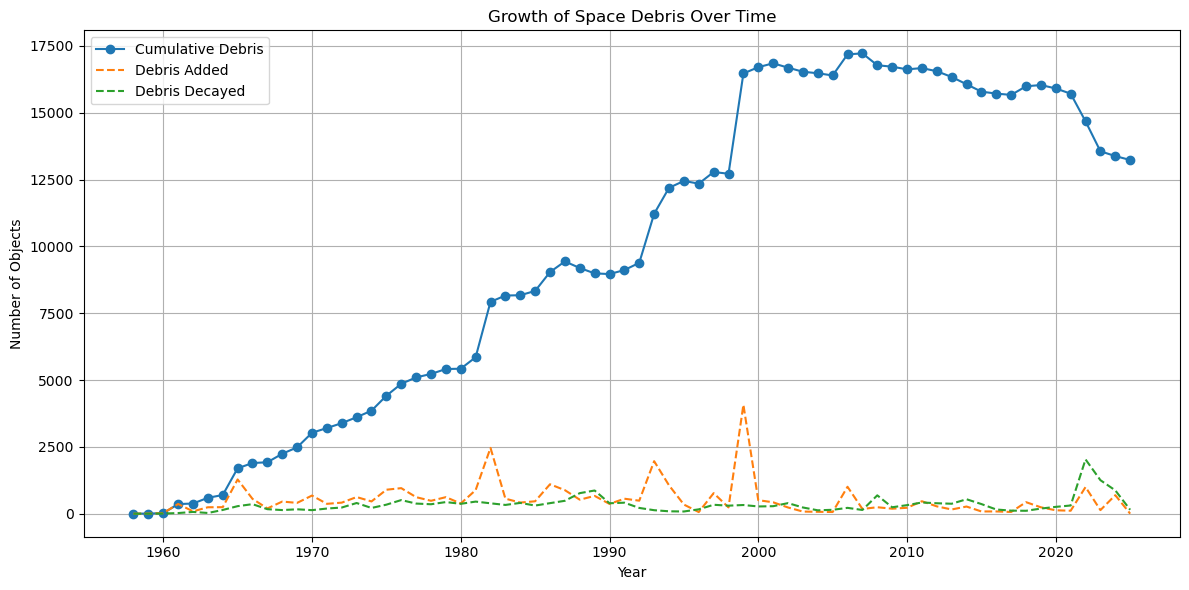

In [18]:
# Plot debris accumulation

plt.figure(figsize=(12, 6))
plt.plot(summary.index, summary["Cumulative_Debris"], label="Cumulative Debris", marker='o')
plt.plot(summary.index, summary["Debris_Added"], label="Debris Added", linestyle='--')
plt.plot(summary.index, summary["Debris_Decayed"], label="Debris Decayed", linestyle='--')

plt.title("Growth of Space Debris Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Objects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
debris_df[debris_df['decay_year'] > 2020]['launch_year'].value_counts()

launch_year
1982    1798
1999     422
1993     376
2022     311
1997     206
        ... 
1980       3
1965       2
1988       2
2003       1
1989       1
Name: count, Length: 62, dtype: int64

In [23]:
debris_df[debris_df['launch_year'] == 1982]['object_name'].value_counts()

object_name
COSMOS 1408 DEB    1806
SALYUT 7 DEB        197
COSMOS 1375 DEB      61
METEOR 2-8 DEB       52
COSMOS 1405 DEB      31
                   ... 
JANUS-1               0
JAISAT-1              0
JAGSAT 1              0
JACKAL X-1L-002       0
JASON-3               0
Name: count, Length: 21985, dtype: int64


We see a huge uptrend in debris growth over time, with a slight downturn starting at about 2010.  Upon closer inspection we can see a big driver of this downtrend was from the decay of a large number of pieces of debris from the Cosmos 1408 which was blown up by Russia as part of an anti-satellite missile test.  Debris growth is expected to resume in future years


# Goal 2

- Reduce projected debris growth in Low Earth Orbit (LEO)

In [28]:
%store -r leo_path

## Upload leo data and split

In [71]:
# Load dataset
df = pd.read_parquet(leo_path)

# Drop ID features
cols_to_drop = ['object_id', 'norad_cat_id', 'object_name']
df.drop(columns = cols_to_drop, inplace = True)

# Ensure 'object_type' is first column so the algorithm will know it's the target
cols = ["object_type"] + [col for col in df.columns if col != "object_type"]
df = df[cols]

# Label encode target
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['object_type'] = le.fit_transform(df['object_type'])

#Change date column to be more useful
df['launch_year'] = df['launch_date'].dt.year
df['launch_month'] = df['launch_date'].dt.month
df['launch_day'] = df['launch_date'].dt.day
df['launch_dayofweek'] = df['launch_date'].dt.dayofweek
df.drop(columns = 'launch_date', inplace = True)

# # Encode categorical variables
features_to_encode = ['country', 'launch_site', 'rcs_size']
df = pd.get_dummies(df, columns = features_to_encode, drop_first = True)

# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save Parquet files
train_df.to_parquet(f"{current_path}/data/modeling_data/train.parquet", index=False)
test_df.to_parquet(f"{current_path}/data/modeling_data/test.parquet", index=False)

print("✅ Data Preprocessing Complete")

✅ Data Preprocessing Complete


## Ingest modeling data into s3

In [72]:
# Upload files to S3
train_path = f"s3://{bucket}/data/modeling_data/train_goal2.parquet"
test_path = f"s3://{bucket}/data/modeling_data/test_goal2.parquet"

s3_client = boto3.client("s3")
s3_client.upload_file(f"{current_path}/data/modeling_data/train.parquet", bucket, "data/modeling_data/train_goal2.parquet")
s3_client.upload_file(f"{current_path}/data/modeling_data/test.parquet", bucket, "data/modeling_data/test_goal2.parquet")

print(f"✅ Data uploaded to {train_path}")
print(f"✅ Data uploaded to {test_path}")

✅ Data uploaded to s3://sagemaker-us-east-1-662949783070/data/modeling_data/train_goal2.parquet
✅ Data uploaded to s3://sagemaker-us-east-1-662949783070/data/modeling_data/test_goal2.parquet


## Define container and train model

In [ ]:
xgboost.set_hyperparameters?

In [130]:
# Define SageMaker XGBoost container

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

xgboost = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/goal2_output",
    sagemaker_session=sess
)

# Set hyperparameters
xgboost.set_hyperparameters(
    objective="multi:softmax",
    num_class=df["object_type"].nunique(),
    eval_metric="mlogloss,merror",
    num_round=100,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=2
)

# Define input format
train_input = TrainingInput(train_path, content_type="parquet")
test_input = TrainingInput(test_path, content_type="parquet")

# Train model
xgboost.fit({"train": train_input, "validation": test_input})

print("✅ Training Complete")

[04/10/25 20:12:01] INFO     Ignoring unnecessary instance type: None.                            ]8;id=708849;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=996870;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

[04/10/25 20:12:03] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=249773;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=699933;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=10760;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=598205;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-10-20-12-03-559                                             

2025-04-10 20:12:03 Starting - Starting the training job...
..25-04-10 20:12:32 Starting - Preparing the instances for training.
..25-04-10 20:12:53 Downloading - Downloading input data.
.....04-10 20:13:39 Downloading - Downloading the training image.
..25-04-10 20:14:29 Training - Training image download completed. Training in progress..
2025-04-10 20:15:05 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-04-10 20:14:35.010 ip-10-0-230-86.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-10 20:14:35.033 ip-10-0-230-86.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-10:20:14:35:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-10:20:14:35:I

## Pull metrics from model

In [131]:
from sagemaker.analytics import TrainingJobAnalytics

training_job = xgboost.latest_training_job.name

metrics_df = TrainingJobAnalytics(training_job).dataframe()

metrics_df.head()

[04/10/25 20:15:56] WARNING  Warning: No metrics called train:mae found                            ]8;id=577952;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=232667;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:mae found                       ]8;id=826104;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=739205;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:macro_precision found           ]8;id=921950;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=878887;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:cox-nloglik found                    ]8;id=418054;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=143955;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:f1 found                        ]8;id=330612;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=975091;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:precision_macro found           ]8;id=763895;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=565789;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:cox-nloglik found               ]8;id=741235;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=274096;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:accuracy found                       ]8;id=26987;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=519245;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

[04/10/25 20:15:57] WARNING  Warning: No metrics called train:mse found                            ]8;id=998880;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=204730;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:ndcg found                           ]8;id=97645;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=518824;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:map found                       ]8;id=617017;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=813977;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:rmse found                           ]8;id=870004;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=12962;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:accuracy found                  ]8;id=271720;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=4295;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:balanced_accuracy found         ]8;id=798035;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=473206;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:rmse found                      ]8;id=359702;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=864998;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:mse found                       ]8;id=292777;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=633225;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:ndcg found                      ]8;id=903460;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=71668;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:macro_recall found              ]8;id=995066;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=69841;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:f1 found                             ]8;id=12492;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=129185;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called validation:recall_macro found              ]8;id=198472;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=846615;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called train:map found                            ]8;id=687524;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=459666;file:///opt/conda/lib/python3.11/site-packages/sagemaker/analytics.py#387\387]8;;\

,timestamp,metric_name,value
0,0.0,train:merror,0.053665
1,0.0,train:mlogloss,0.583845
2,0.0,validation:merror,0.062955
3,0.0,validation:mlogloss,0.594670


## Deploy and test model

In [175]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

predictor = xgboost.deploy(
    instance_type="ml.m5.large",
    initial_instance_count=1,
    serializer=CSVSerializer(),
    deserializer=StringDeserializer()
)

# Subset all the features and convert string values to boolean

features_only = test_df.drop(columns=["object_type"])
features_only = features_only.astype({col: int for col in features_only.select_dtypes('bool').columns})

# Take a sample to make a prediction on 
sample_row = features_only.iloc[0].tolist()
prediction = predictor.predict(sample_row)

# Parse the output to get the result
parsed = json.loads(prediction)

# Extract the predicted class index
pred_class_index = int(parsed["predictions"][0]["score"])

# Convert to original label
predicted_class = le.inverse_transform([pred_class_index])[0]
true_label = le.inverse_transform([test_df['object_type'].iloc[0]])[0]
print(f"🚀 Predicted Object Type: {predicted_class}")
print(f"🚀 Actual Object Type: {true_label}")

🚀 Predicted Object Type: PAYLOAD
🚀 Actual Object Type: PAYLOAD


In [176]:
# close end point after to avoid charges

predictor.delete_endpoint()

[04/10/25 21:24:42] INFO     Deleting endpoint configuration with name:                             ]8;id=117758;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=637336;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             sagemaker-xgboost-2025-04-10-21-10-48-296                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-04-10-21-10-48-296 ]8;id=962321;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=425981;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\

# Goal 3

- Identify top 5 highest denisty debris fields

## Query Athena to get data for clustering

In [17]:
# Use Athena to combine Satcat and Esa data on relevant features

%store -r s3_staging_dir

conn = connect(region_name = region, s3_staging_dir = s3_staging_dir, schema_name = 'space_project')

In [66]:
# Write statement to combine satcat and esa and filter by objects that are debris and still in orbit

statement = """
SELECT 
s.object_name,
e.diameter,
e.span,
e.xsectavg,
s.period,
s.inclination,
s.apogee,
s.perigee
FROM esa e
INNER JOIN satcat s
ON e.object_id = s.object_id
WHERE s.object_type = 'DEBRIS'
AND s.orbit_type = 'ORB'
"""

In [67]:
cluster_df = pd.read_sql(statement, conn)

In [68]:
# check for na's and duplicates

cluster_df.isna().sum()

object_name    0
diameter       0
span           0
xsectavg       0
period         0
inclination    0
apogee         0
perigee        0
dtype: int64

In [69]:
cluster_df.duplicated().sum()

155

In [70]:
# Separate features and ID

X = cluster_df.iloc[:, 1:]

## Use HBDSCAN to identify clusters of debris

### Hyperparameter grid search based on lowest noise rate (percent of objects that aren't put into a cluster)

In [71]:
import hdbscan
import itertools
import numpy as np
import pandas as pd

# Parameter grid to tune algorithm
min_cluster_sizes = [10, 20, 30, 50]
min_samples_list = [5, 10, 15]
epsilons = [0.0, 0.1, 0.2]

# Store results

results = []

for min_cluster_size, min_samples, epsilon in itertools.product(min_cluster_sizes, min_samples_list, epsilons):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon
    )
    labels = clusterer.fit_predict(X)

    noise_rate = np.sum(labels == -1) / len(labels)
    n_clusters = len(np.unique(labels[labels != -1]))
    
    results.append({
        'min_cluster_size': min_cluster_size,
        'min_samples': min_samples,
        'epsilon': epsilon,
        'n_clusters': n_clusters,
        'noise_rate': noise_rate
    })

# Convert to DataFrame and find best
results_df = pd.DataFrame(results)
best_config = results_df.loc[results_df['noise_rate'].idxmin()]

### Fit cluster

In [72]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best_config['min_cluster_size']),
    min_samples=int(best_config['min_samples']),
    cluster_selection_epsilon=float(best_config['epsilon'])
)

labels = clusterer.fit_predict(X)
cluster_df['cluster'] = labels

In [73]:
n_clusters = len(np.unique(labels[labels != -1]))
noise_rate = np.sum(labels == -1) / len(labels)

print(f"Clusters: {n_clusters}")
print(f"Noise rate: {noise_rate:.2%}")

Clusters: 33
Noise rate: 41.79%


### Use PCA decomp and plot the top 5 clusters

In [80]:
# Exclude noise (-1)
cluster_counts = cluster_df[cluster_df['cluster'] != -1]['cluster'].value_counts()
top_5_clusters = cluster_counts.head(5).index.tolist()

df_top5 = cluster_df[cluster_df['cluster'].isin(top_5_clusters)]
X_top5 = X[cluster_df['cluster'].isin(top_5_clusters)]
labels_top5 = df_top5['cluster'].values


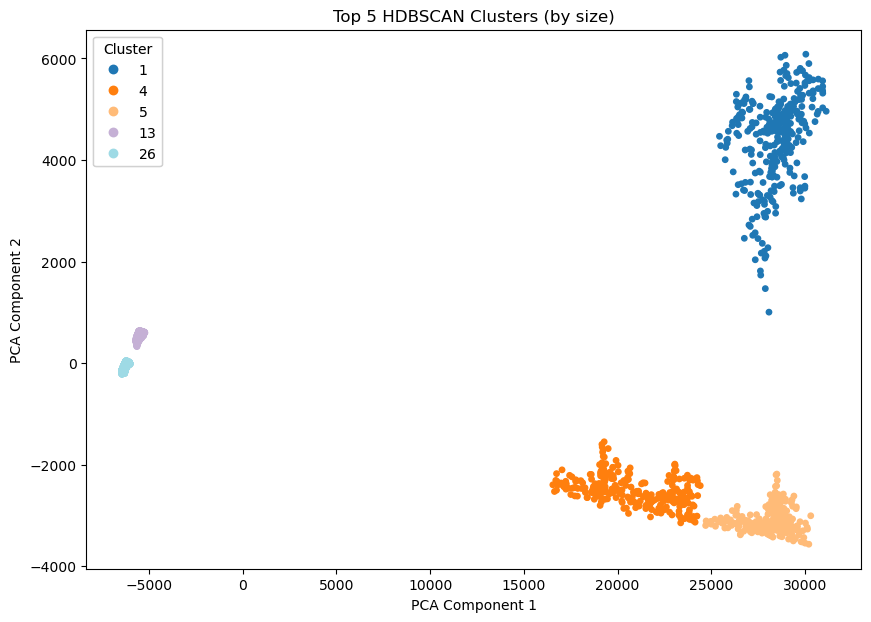

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_top5)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(components[:, 0], components[:, 1], c=labels_top5, cmap = 'tab20', s=15)
plt.title("Top 5 HDBSCAN Clusters (by size)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Legend with cluster labels
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.show()

### Save data 

In [100]:
df_top5.to_parquet(f"{current_path}/data/results/clustering.parquet", index = False)

s3_client.upload_file(f"{current_path}/data/results/clustering.parquet", bucket, "data/goal3_output/clustering.parquet")

# Goal 4

- Predicting collision probabilty of lost objects


We'll attempt to accurately predict collision probabilities for the lost objects.  The challenge is that the collision data we have contains features not available for lost objects.  Using Norad Cat Id's, we can join the Satcat data to the collision data and lost object data so tey have common features, and see if any of those hold predictive power


## Query data to prepare for modeling

In [142]:
statement = """
SELECT
    c.norad_cat_id_1,
    c.norad_cat_id_2,
    c.max_prob,
    c.object_name_1,
    c.object_name_2,
    
    s1.owner AS owner_1,
    s1.object_type AS object_type_1,
    s1.launch_date AS launch_date_1,
    s1.launch_site AS launch_site_1,
    s1.period AS period_1,
    s1.inclination AS inclination_1,
    s1.apogee AS apogee_1,
    s1.perigee AS perigee_1,
    s1.orbit_type AS orbit_type_1,

    s2.owner AS owner_2,
    s2.object_type AS object_type_2,
    s2.launch_date AS launch_date_2,
    s2.launch_site AS launch_site_2,
    s2.period AS period_2,
    s2.inclination AS inclination_2,
    s2.apogee AS apogee_2,
    s2.perigee AS perigee_2,
    s2.orbit_type AS orbit_type_2

FROM collision c
INNER JOIN satcat s1
    ON CAST(c.norad_cat_id_1 AS VARCHAR) = CAST(s1.norad_cat_id AS VARCHAR)
INNER JOIN satcat s2
    ON CAST(c.norad_cat_id_2 AS VARCHAR) = CAST(s2.norad_cat_id AS VARCHAR)
WHERE s1.orbit_type = 'ORB'
  AND s2.orbit_type = 'ORB'
"""

In [143]:
combo_df = pd.read_sql(statement, conn)

In [144]:
# Check for duplicates and remove

combo_df.duplicated().sum()

507

In [146]:
combo_df = combo_df.drop_duplicates()

In [148]:
# Ingest dataframe

combo_df.to_parquet(f'{current_path}/data/modeling_data/auto_ml_data.parquet', index = False)
combo_df.to_parquet(f"s3://{bucket}/data/modeling_data/goal4/auto_ml_data.parquet", index = False)

## Set up AutoML

In [4]:
autopilot_full_train_s3_uri = f"s3://{bucket}/data/modeling_data/goal4/auto_ml_data.parquet"

In [153]:
%store autopilot_full_train_s3_uri

Stored 'autopilot_full_train_s3_uri' (str)


## Set up model path and job configuration

In [5]:
prefix_model_output = "models/autopilot"

model_output_s3_uri = "s3://{}/{}".format(bucket, prefix_model_output)

print(model_output_s3_uri)

s3://sagemaker-us-east-1-662949783070/models/autopilot


In [6]:
# set up the training job

max_candidates = 3

job_config = {
    "CompletionCriteria": {
        "MaxRuntimePerTrainingJobInSeconds": 900,
        "MaxCandidates": max_candidates,
        "MaxAutoMLJobRuntimeInSeconds": 5400,
    },
}

input_data_config = [
    {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "{}".format(autopilot_full_train_s3_uri)}},
        "TargetAttributeName": "max_prob",
        'ContentType': 'x-application/vnd.amazon+parquet'
    }
]

output_data_config = {"S3OutputPath": "{}".format(model_output_s3_uri)}
ProblemType = 'Regression'
AutoMLJobObjective = {'MetricName': 'RMSE'}

In [7]:
# Check for any existing jobs

sm.list_auto_ml_jobs(
    StatusEquals = 'InProgress'
)

{'AutoMLJobSummaries': [],
 'ResponseMetadata': {'RequestId': '6104fb53-f90f-4a8e-84ed-70b5b516e3cb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6104fb53-f90f-4a8e-84ed-70b5b516e3cb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '25',
   'date': 'Mon, 14 Apr 2025 15:43:58 GMT'},
  'RetryAttempts': 0}}

In [8]:
# This establishes the current ML job

from time import gmtime, strftime, sleep


%store -d  auto_ml_job_name
%store -r auto_ml_job_name

try:
    auto_ml_job_name
except NameError:
    timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
    auto_ml_job_name = "automl-full-third-" + timestamp_suffix
    print("Created AutoMLJobName: " + auto_ml_job_name)

no stored variable or alias auto_ml_job_name
Created AutoMLJobName: automl-full-third-14-15-44-02


## Create AutoML job

In [9]:
sm.create_auto_ml_job(
    AutoMLJobName = auto_ml_job_name,
    InputDataConfig = input_data_config,
    OutputDataConfig = output_data_config,
    AutoMLJobConfig = job_config,
    RoleArn = role,
    ProblemType = 'Regression',
    AutoMLJobObjective = {'MetricName': 'RMSE'}
)

{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-14-15-44-02',
 'ResponseMetadata': {'RequestId': 'e892464b-dd0f-40de-bd3e-a1a0c6ca9f40',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e892464b-dd0f-40de-bd3e-a1a0c6ca9f40',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Mon, 14 Apr 2025 15:44:26 GMT'},
  'RetryAttempts': 0}}

## Status updates

In [11]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while (
    "AutoMLJobStatus" not in job_description_response.keys()
    and "AutoMLJobSecondaryStatus" not in job_description_response.keys()
):
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet started. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for Autopilot Job to start...")
    sleep(15)

print("[OK] AutoMLJob started.")

[OK] AutoMLJob started.


In [12]:
%%time

# Analyzing data and generating reports

job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]

if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("Starting", "AnalyzingData"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Data analysis phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
[OK] Data analysis phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-14-15-44-02",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "

In [13]:
# Check that aritifacts were generated

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while "AutoMLJobArtifacts" not in job_description_response.keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the artifacts. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for AutoMLJobArtifacts...")
    sleep(15)

print("[OK] AutoMLJobArtifacts generated.")

[OK] AutoMLJobArtifacts generated.


In [14]:
# Check that data exploration notebook was created

while "DataExplorationNotebookLocation" not in job_description_response["AutoMLJobArtifacts"].keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the notebooks. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for DataExplorationNotebookLocation...")
    sleep(15)

print("[OK] DataExplorationNotebookLocation found.")

[OK] DataExplorationNotebookLocation found.


In [15]:
# Save data exploration and artifacts to paths

generated_resources = job_description_response["AutoMLJobArtifacts"]["DataExplorationNotebookLocation"]
download_path = generated_resources.rsplit("/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb")[0]
job_id = download_path.rsplit("/", 1)[-1]

In [16]:
# Copy exploration notebook and artifacts to workspace

try:
    !aws s3 cp --recursive $download_path .
except:
    print('Could not download the generated resources. Make sure the path is correct.')

download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb724611b74721c70885/generated_module/candidate_data_processors/dpp0.py to generated_module/candidate_data_processors/dpp0.py
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb724611b74721c70885/generated_module/candidate_data_processors/dpp1.py to generated_module/candidate_data_processors/dpp1.py
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb724611b74721c70885/generated_module/MANIFEST.in to generated_module/MANIFEST.in
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb

In [17]:
%%time

# Check progress of feature engineering

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("FeatureEngineering"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Feature engineering phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress

In [18]:
%%time

# Check progress of model tuning

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("ModelTuning"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Model tuning phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress MergingAutoMLTaskReports
[OK] Model tuning phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:662949783070:automl-job/automl-full-third-14-15-44-02",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb724611b74721c70885/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/sagemaker-automl-candidates/automl-full-third-14-15-44-02-pr-1-9ec4ef2feb724611b74721c70885/notebooks/SageMakerAutopilotDa

In [19]:
%%time

# Check to see when job is completed

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
print(job_status)
if job_status not in ("Stopped", "Failed"):
    while job_status not in ("Completed"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        print(job_status)
        sleep(10)
    print("[OK] Autopilot Job completed.\n")
else:
    print(job_status)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
[OK] Autopilot Job completed.

CPU times: user 294 ms, sys: 28.7 ms, total: 323 ms
Wall time: 11min 46s


## Pull analytics

In [20]:
candidates_response = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
)

candidates = candidates_response['Candidates']

for index, candidate in enumerate(candidates):
    print(
        str(index)
        + "  "
        + candidate["CandidateName"]
        + "  "
        + str(candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    )

0  automl-full-third-14-15-44-02z8C-003-9a67d3c3  0.0012499999720603228
1  automl-full-third-14-15-44-02z8C-002-df5c53df  0.0005099999834783375
2  automl-full-third-14-15-44-02z8C-001-c2ed7183  0.00023999999393709004


In [41]:
candidates_response['Candidates'][2]['CandidateProperties']

{'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/explainability/output',
  'ModelInsights': 's3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/model_monitor/output'},
 'CandidateMetrics': [{'MetricName': 'MAE',
   'Value': 3.9999998989515007e-05,
   'Set': 'Validation',
   'StandardMetricName': 'MAE'},
  {'MetricName': 'RMSE',
   'Value': 0.00023999999393709004,
   'Set': 'Validation',
   'StandardMetricName': 'RMSE'},
  {'MetricName': 'MSE',
   'Value': 0.0,
   'Set': 'Validation',
   'StandardMetricName': 'MSE'},
  {'MetricName': 'R2',
   'Value': -0.002589999930933118,
   'Set': 'Validation',
   'StandardMetricName': 'R2'}]}


The 3rd model produced the best RMSE value at .00024.  This is a desirable result, however upoin closer examination, the R^2 value is shown to be -0.0026.  This means the model explains none of the variance found in the data.  This shows that the features available for the lost objects are not enough to accurately predict their collision probability with other objects and that more advanced modeling will need to be pursued, and more relevant data will need to be gathered


In [34]:
# Get analytics and save dataframe

pd.set_option('display.max_columns', None)

from sagemaker.analytics import ExperimentAnalytics, TrainingJobAnalytics

exp = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=auto_ml_job_name + "-aws-auto-ml-job",
)

df = exp.dataframe()
df.head(3)

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,colsample_bytree,eta,eval_metric,gamma,lambda,max_depth,min_child_weight,num_round,objective,save_model_on_termination,subsample,ObjectiveMetric - Min,ObjectiveMetric - Max,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count,train:rmse - Min,train:rmse - Max,train:rmse - Avg,train:rmse - StdDev,train:rmse - Last,train:rmse - Count,train:mae - Min,train:mae - Max,train:mae - Avg,train:mae - StdDev,train:mae - Last,train:mae - Count,train:mse - Min,train:mse - Max,train:mse - Avg,train:mse - StdDev,train:mse - Last,train:mse - Count,validation:mse - Min,validation:mse - Max,validation:mse - Avg,validation:mse - StdDev,validation:mse - Last,validation:mse - Count,validation:mae - Min,validation:mae - Max,validation:mae - Avg,validation:mae - StdDev,validation:mae - Last,validation:mae - Count,validation:rmse - Min,validation:rmse - Max,validation:rmse - Avg,validation:rmse - StdDev,validation:rmse - Last,validation:rmse - Count,validation:r2 - Min,validation:r2 - Max,validation:r2 - Avg,validation:r2 - StdDev,validation:r2 - Last,validation:r2 - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments,SageMaker.ModelName,SageMaker.ModelPrimary.DataUrl,SageMaker.ModelPrimary.Image,SageMaker.TransformInput - MediaType,SageMaker.TransformInput - Value,SageMaker.TransformOutput - MediaType,SageMaker.TransformOutput - Value,processor_module,sagemaker_program,sagemaker_submit_directory,code - MediaType,code - Value,auto_ml_job_arn,content_type,enable_stratified_split,enable_validation_split,input_channel_mode,job_name,label_col,max_dataset_size,max_subsampled_dataset_size,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,ds - MediaType,ds - Value
0,automl-full-third-14-15-44-02z8C-001-c2ed7183-...,automl-full-third-14-15-44-02z8C-001-c2ed7183-...,arn:aws:sagemaker:us-east-1:662949783070:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.12xlarge,50.0,validation:rmse,0.000002,0.674964,0.075729,"mse,mae,rmse,r2",6.995113,0.000008,4.0,8.265404,155.0,reg:squarederror,true,0.638802,0.12116,0.46211,0.256867,0.106211,0.12116,18.0,0.11198,0.46211,0.249235,0.108439,0.11198,19.0,0.11198,0.46210,0.249233,0.108437,0.11198,19.0,0.01254,0.21354,0.073257,0.06072,0.01254,19.0,0.01254,0.21355,0.073262,0.060723,0.01254,19.0,0.11199,0.46211,0.249242,0.108438,0.11199,19.0,0.11199,0.46211,0.249242,0.108438,0.11199,19.0,-3.814843e+06,-262243.77254,-1.369004e+06,1.082980e+06,-262243.772540,18.0,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,NaN,s3://sagemaker-us-east-1-662949783070/models/a...,[automl-full-third-14-15-44-02z8C-001-c2ed7183...,[automl-full-third-14-15-44-02-aws-auto-ml-job],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,automl-full-third-14-15-44-02z8C-003-9a67d3c3-...,automl-full-third-14-15-44-02z8C-003-9a67d3c3-...,arn:aws:sagemaker:us-east-1:662949783070:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.12xlarge,50.0,validation:rmse,0.000027,0.508760,0.045967,"mse,mae,rmse,r2",0.000007,0.000002,5.0,0.046783,244.0,reg:squarederror,true,0.522517,0.00000,0.47699,0.000000,0.000000,0.00125,0.0,0.00000,0.47699,0.000000,0.000000,0.00047,0.0,0.00000,0.47698,0.000000,0.000000,0.00005,0.0,0.00000,0.22751,0.000000,0.00000,0.00000,0.0,0.00000,0.22752,0.000000,0.000000,0.00000,0.0,0.00000,0.47699,0.000000,0.000000,0.00007,0.0,0.00000,0.47699,0.000000,0.000000,0.00125,0.0,-4.064474e+06,0.00000,0.000000e+00,0.000000e+00,-26.751869,0.0,application/x-recordio-protobuf,s3://sagemaker-us-east-1-662949783070/models/a...,application/x-r

In [44]:
# Copy 3rd model documentation to workspace for closer examination

!aws s3 cp $"s3://sagemaker-us-east-1-662949783070/models/autopilot/{auto_ml_job_name}/documentation/" ./automl-docs --recursive

download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/explainability/config/analysis_config.json to automl-docs/explainability/config/analysis_config.json
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/explainability/output/automl-full-third-14-15-44-02z8C-001-c2ed7183/explanations_shap/out.csv/._SUCCESS.crc to automl-docs/explainability/output/automl-full-third-14-15-44-02z8C-001-c2ed7183/explanations_shap/out.csv/._SUCCESS.crc
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/explainability/output/automl-full-third-14-15-44-02z8C-001-c2ed7183/analysis.json to automl-docs/explainability/output/automl-full-third-14-15-44-02z8C-001-c2ed7183/analysis.json
download: s3://sagemaker-us-east-1-662949783070/models/autopilot/automl-full-third-14-15-44-02/documentation/explainability/output/automl-full-third-14-15-44-02z8

# References

1) AWS. (n.d.). Amazon SageMaker Documentation. Retrieved April 13, 2025, from https://docs.aws.amazon.com/sagemaker/ 

2) CelesTrak. (n.d.). Satellite tracking and collision data. Retrieved April 13, 2025, from https://www.celestrak.com   

3) European Space Agency. (n.d.). Space Debris and DISCOS Database. Retrieved April 13, 2025, from   https://www.esa.int/Safety_Security/Space_Debris   

4) Kaggle. (n.d.). Public Datasets on Satellite and Debris Tracking. Retrieved April 13, 2025, from https://www.kaggle.com   

5) NASA Orbital Debris Program Office. (n.d.). Orbital Debris Research and Reports. Retrieved April 13, 2025, from   https://orbitaldebris.jsc.nasa.gov   